# Kaggle team name: vijf5!

# Members:
1. Jesse Coenraad -> JesseCoenraad
2. Jordan van Sintanneland -> JordanvanSint
3. Casper Priem -> CasperPriem
4. Jassar Hasiba -> UrClades

### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

from scipy.signal import find_peaks
from scipy.fft import fft, ifft
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, KFold
from itertools import product

from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.api as smt

from prophet import Prophet
import logging

import os


from tqdm import tqdm_notebook as tqdm


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


### Data inladen

In [3]:
train = pd.read_csv('train.csv', parse_dates=True)
test = pd.read_csv('test.csv')

# 1. Exploratieve Data Analyse

## 1.1 Toon de datatypes en basisstatistieken van iedere kolom

In [4]:
display(train.head())
display(train.info())
display(train.describe())

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   16637 non-null  object 
 1   holiday     16637 non-null  int64  
 2   weathersit  16637 non-null  int64  
 3   temp        16637 non-null  float64
 4   atemp       16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


None

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


### 1.1.1 Valt hier iets op?

- Geen missende waarde
- De 'temp', 'atemp', 'hum' en 'windspeed' zijn al genormaliseerd
- 'date_hour', is geen DateTime data type

### 1.1.2 Beschrijf de kolommen

- date_hour: Je hebt informatie over de periode van 1-1-2011 t/m 30-11-2012, metingen per uur
- holiday: Vakantiedag of geen vakantiedag
- weathersit: Weersituatie:
    1. Helder, licht bewolkt, deels bewolkt
    2. Mistig , mistig en licht bewolkt
    3. Lichte sneeuw, lichte regen, lichte regen en onweer, zwaar bewolkt, lichte regen en zwaar bewolkt
    4. Zware regen,  hagel,  zware mist, sneeuw
- temp: genormaliseerde temperatuur
- atemp: genormaliseerde gevoelstemperatuur
- hum: genormaliseerde luchtvochtigheid
- windspeed: genormaliseerde windsnelheid
- cnt: het aantal dat per uur is verhuurd

## 1.2 Voeg tijdserie elementen toe en gebruik passende visualistaites om relevante patronen zichtbaar te maken.

Hier wordt de 'date_hour' kolom omgezet naar een DateTime data type, zodat er Time Series modellen mee kunnen worden gemaakt.

In [5]:
train['date_hour'] = pd.to_datetime(train['date_hour'])
test['date_hour'] = pd.to_datetime(test['date_hour'])

Aangezien we in de EDA willen kijken naar de correlaties tussen verschillende time series features en de target kolom worden hieronder door middel van een functie alvast aan de train- EN testset deze features toegevoegd. Dit zou beter bij het hoofdstuk van feature engineering passen, maar op deze manier kunnen we er in de EDA ook nog wat makkelijker mee werken.

In [6]:
def add_date_features(df, datetime_col):
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    
    # Extract features
    df['hour'] = df[datetime_col].dt.hour
    df['day'] = df[datetime_col].dt.dayofweek
    df['dayName'] = df[datetime_col].dt.day_name()
    df['month'] = df[datetime_col].dt.month
    df['week'] = df[datetime_col].dt.isocalendar().week
    df['weekend'] = df['day'].apply(lambda x: 1 if x > 4 else 0)
    
    return df

train = add_date_features(train, 'date_hour')
test = add_date_features(test, 'date_hour')

In [7]:
train

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour,day,dayName,month,week,weekend
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,0,5,Saturday,1,52,1
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,1,5,Saturday,1,52,1
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,2,5,Saturday,1,52,1
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,3,5,Saturday,1,52,1
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,4,5,Saturday,1,52,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,19,4,Friday,11,48,0
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,20,4,Friday,11,48,0
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,21,4,Friday,11,48,0
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163,22,4,Friday,11,48,0


In [8]:
test

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,hour,day,dayName,month,week,weekend
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000,0,5,Saturday,12,48,1
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000,1,5,Saturday,12,48,1
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,2,5,Saturday,12,48,1
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,3,5,Saturday,12,48,1
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,4,5,Saturday,12,48,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,2012-12-19 19:00:00,0,1,0.38,0.3939,0.50,0.3881,19,2,Wednesday,12,51,0
452,2012-12-19 20:00:00,0,1,0.36,0.3485,0.57,0.2239,20,2,Wednesday,12,51,0
453,2012-12-19 21:00:00,0,1,0.34,0.3182,0.61,0.2239,21,2,Wednesday,12,51,0
454,2012-12-19 22:00:00,0,1,0.34,0.3485,0.61,0.0896,22,2,Wednesday,12,51,0


Plotten van de target kolom 'cnt' ten opzichte van tijdserie elementen

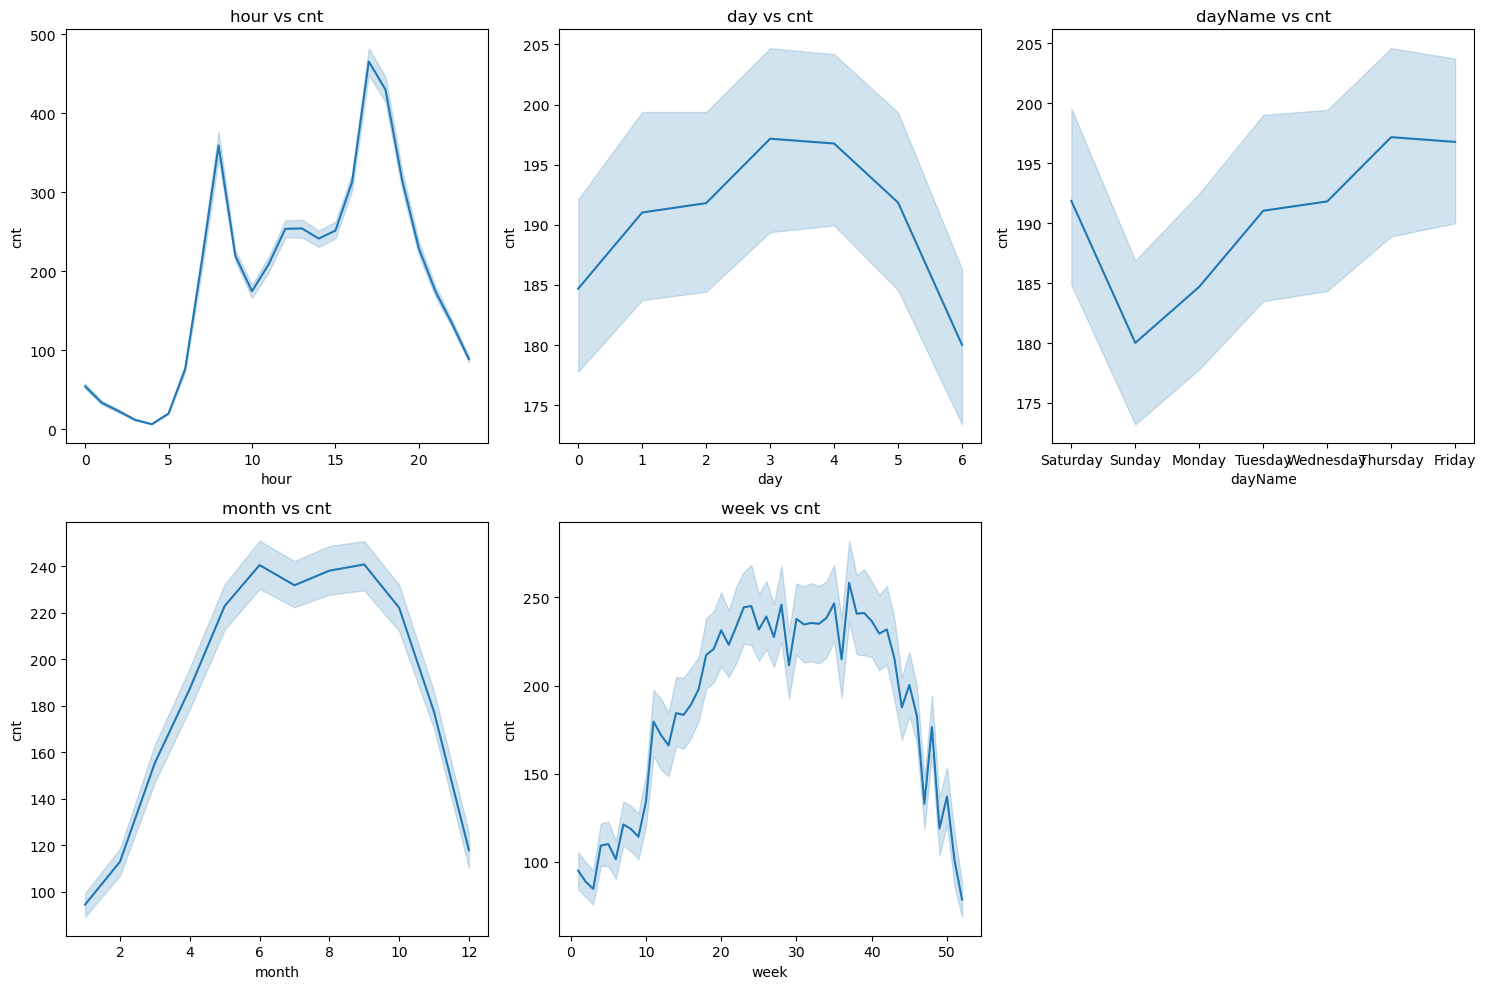

In [9]:

keys = ['hour', 'day', 'dayName', 'month', 'week']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  

for i, key in enumerate(keys):
    row, col = divmod(i, 3)  
    sns.lineplot(data=train, x=key, y='cnt', ax=axes[row, col])
    axes[row, col].set_title(f'{key} vs cnt')

if len(keys) < 6:
    fig.delaxes(axes[1, 2])

plt.tight_layout()  
plt.show()

### 1.2.2 Valt hier iets op?


**Lineplots**
- Hour:

    Er zijn een opvallend patroon in deze grafiek. Zo zijn er grote pieken in het aantal verhuurde producten rond 8 uur 's-ochtends en 6 uur 's-savonds. Daarnaast valt het ook op dat er laat in de avond (vanaf 20:00) en 's-nachts (voor 7:00) een stuk minder wordt verhuurd.

- Day/DayName:

    Het valt op dat op de zondag het aantal verhuurde producten aanzienlijk lager is dan de rest van de dagen. Ook is er een stijgende lijn in het aantal verhuurde producten door de week heen. Dit loopt van zondag (laag aantal) tot vrijdag (hoog aantal).

- Month/Week:

    In het begin en het einde van het jaar is het aantal verhuurde producten een stuk lager dan in het midden van het jaar (winterperiode dus lager, zomerperiode dus hoger). Tijdens de zomerperiode zijn er niet opvallende pieken, het aantal verhuurde producten is wel op zijn hoogst, maar op een consistent aantal.

## 1.3 Relaties

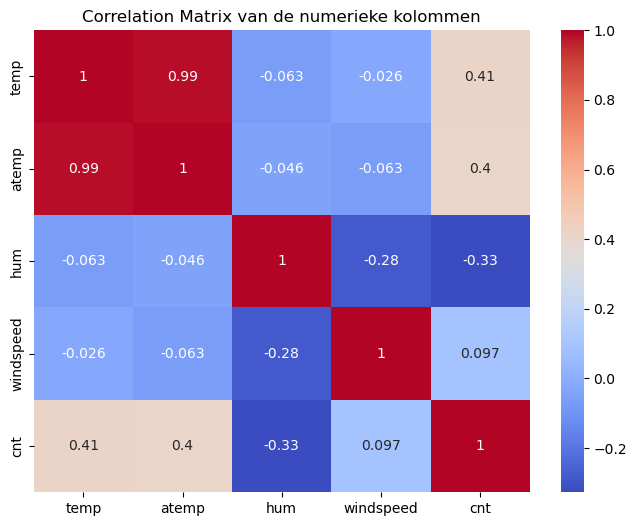

In [10]:
# Correlatiematrix van de numerieke kolommen
plt.figure(figsize=(8, 6))
correlation_matrix = train[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix van de numerieke kolommen')
plt.show()

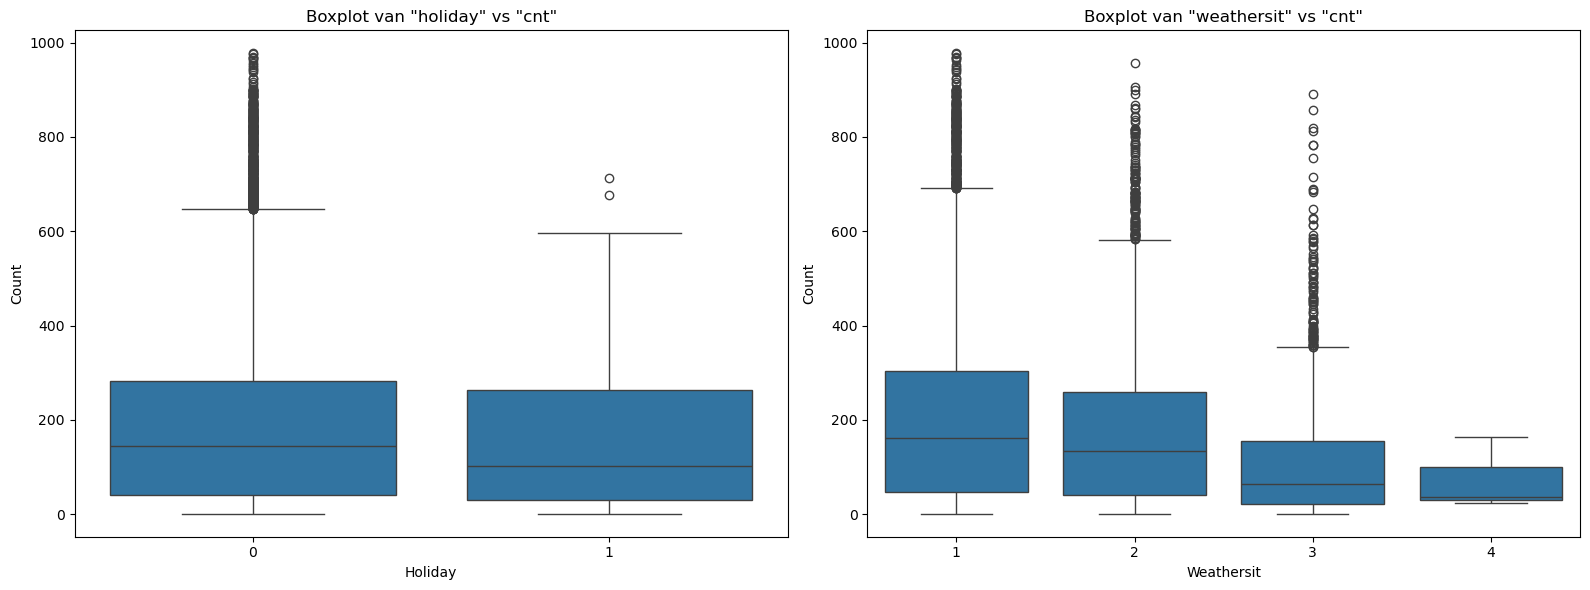

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='holiday', y='cnt', data=train, ax=axes[0])
axes[0].set_title('Boxplot van "holiday" vs "cnt"')
axes[0].set_xlabel('Holiday')
axes[0].set_ylabel('Count')

sns.boxplot(x='weathersit', y='cnt', data=train, ax=axes[1])
axes[1].set_title('Boxplot van "weathersit" vs "cnt"')
axes[1].set_xlabel('Weathersit')
axes[1].set_ylabel('Count')

plt.tight_layout()

plt.show()

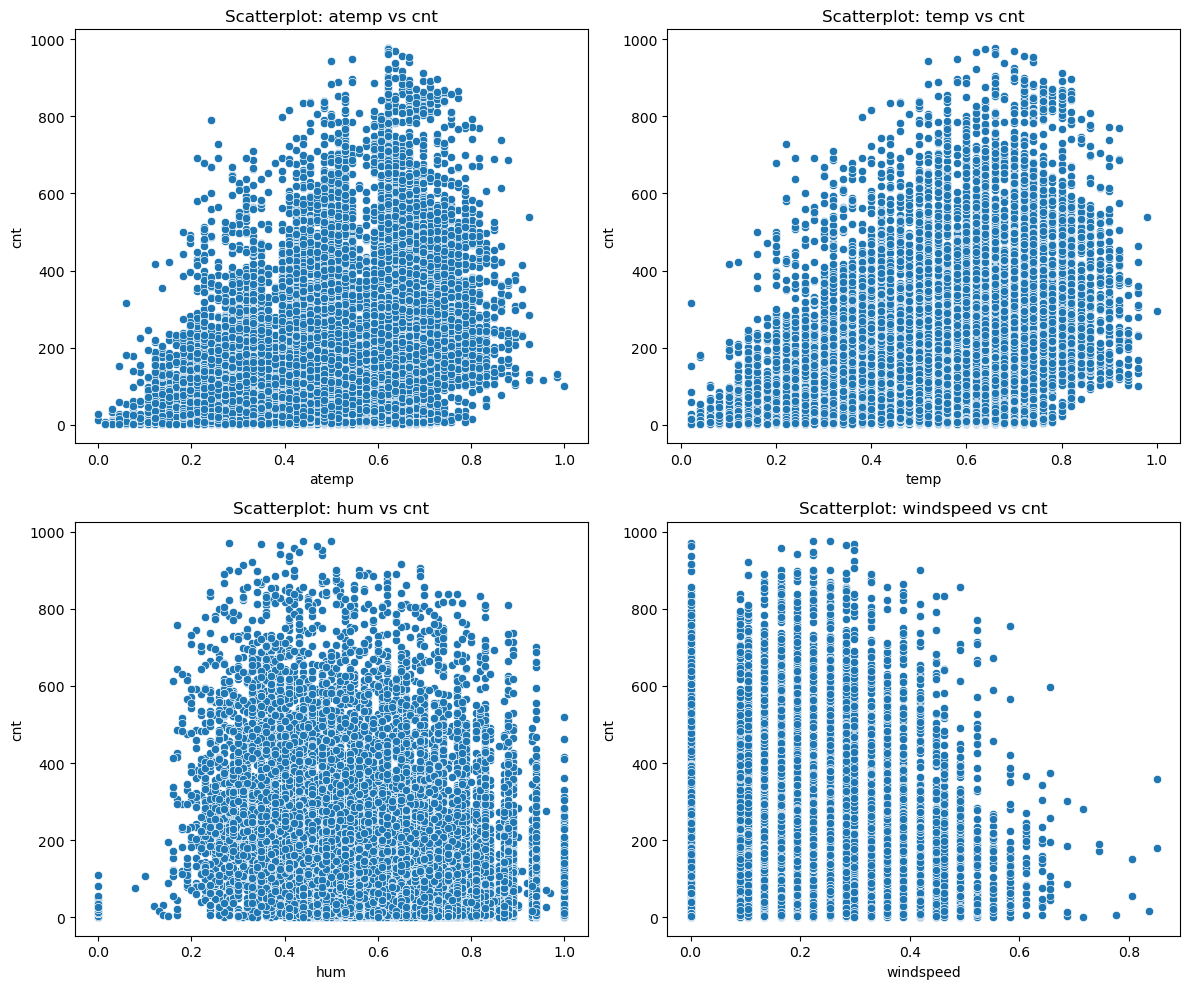

In [12]:
keys = ['atemp', 'temp', 'hum', 'windspeed']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, key in enumerate(keys):
    row, col = divmod(i, 2)  
    sns.scatterplot(data=train, x=key, y='cnt', ax=axes[row, col])
    axes[row, col].set_title(f'Scatterplot: {key} vs cnt')

plt.tight_layout()
plt.show()

#https://www.geeksforgeeks.org/divmod-python-application/

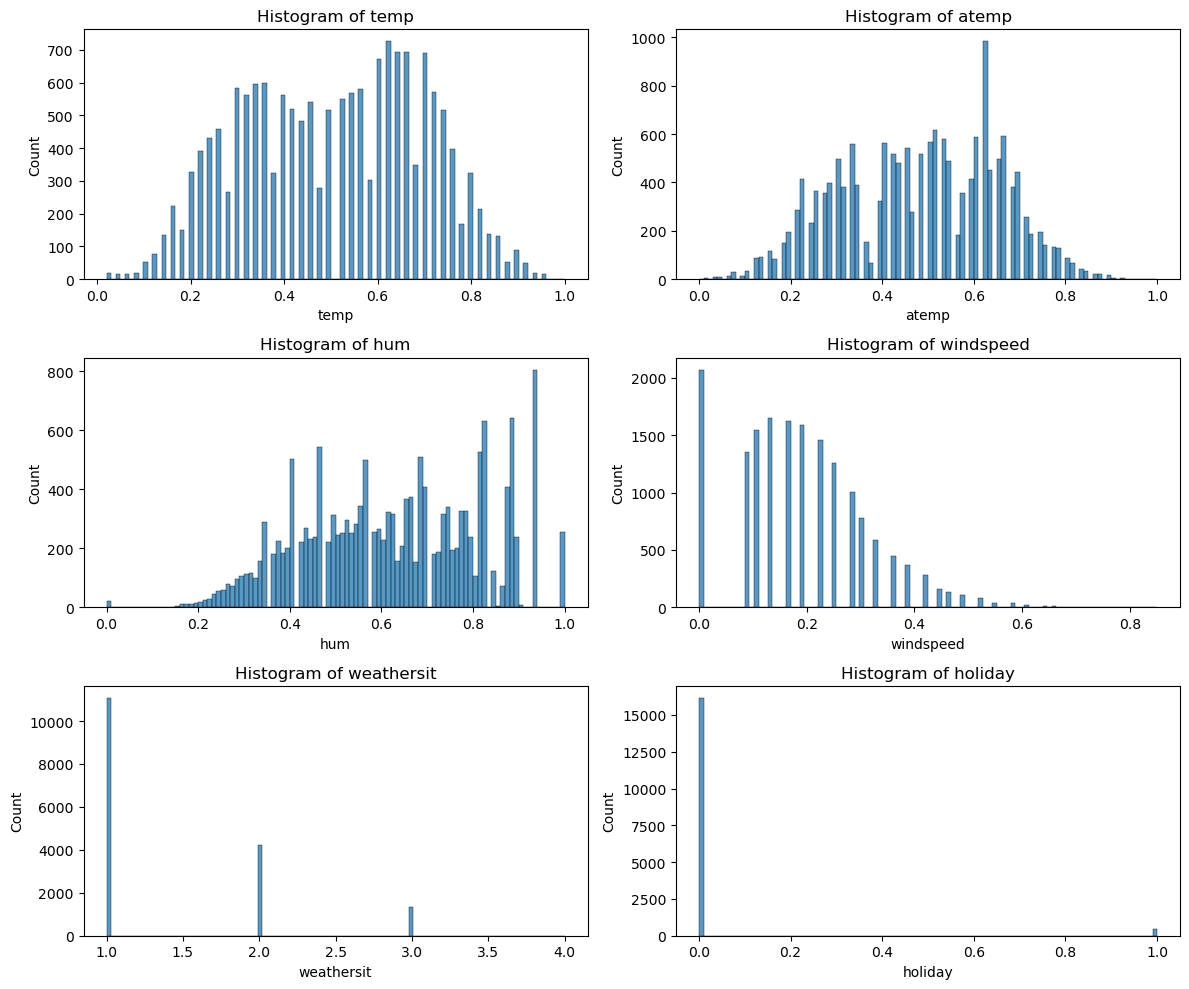

In [13]:
keys = ['temp', 'atemp', 'hum', 'windspeed', 'weathersit', 'holiday']

fig, axes = plt.subplots(3,2 , figsize=(12, 10))

axes = axes.flatten()

for i, key in enumerate(keys):
    sns.histplot(data=train, x=key, bins=100, ax=axes[i])
    axes[i].set_title(f'Histogram of {key}')

plt.tight_layout()
plt.show()

### 1.3.1 Valt hier iets op?

**Correlatiematrix**
- De kolommen 'temp' en 'atemp' zijn zeer sterk gecorreleerd (waarde van 0.99). Dit is vrij logisch, aangezien beide genormaliseerde waardes met betrekking tot de temperatuur bevatten.

- De kolommen 'temp en 'atemp zijn enigzins positief gecorreleerd  (waarde van 0.4 en 0.41) met de 'cnt' kolom. Dit kan erop wijzen dat hogere temperaturen leiden tot een hoger aantal verhuurde producten.

- De 'hum' kolom heeft een negatieve correlatie (waarde van -0.33) met de 'cnt' kolom. Hieruit kan worden afgeleid dat een hogere luchtvochtigheid wellicht een negatieve invloed heeft op het aantal verhuurde producten.

- De 'windspeed' kolom heeft een lichte positieve correlatie (waarde van 0.097) met de 'cnt' kolom. Hieruit valt niet heel veel af te leiden, aangezien de correlatiecoëfficient dicht bij 0 ligt.


**Boxplots**
- 'Weathersit' vs 'cnt': <br>
    De 'weathersit' is ordinaal gemeten. Dit houdt in dat er bij '1' goed weer is en als het richting '4' gaat er slecht weer is (zoals in de kolombeschrijving bovenaan het notebook is beschreven). In de boxplots is te zien dat het aantal verhuurde producten bij '1' vrij hoog is, maar naarmate het richting de '4' gaat steeds verder afneemt. Dit laat zien dat bij slechtere weersomstandigheiden het aantal verhuurde producten lager is.
    
- 'Holiday' vs 'cnt': <br>
    Naast het feit dat er een stuk meer '0' (geen vakantiedag), dan '1' (wel vakantiedag) waardes zijn, zijn er voor de rest geen opvallende dingen in deze grafiek.
    

**Scatterplots**
- Atemp/Temp: <br>
    Het valt op dat bij een hogere temperatuur er meer producten worden verhuurd ten opzichte van een lage temperatuur.

- Hum: <br>
    In deze grafiek is geen duidelijke correlatie / trend te zien.

- Windspeed: <br>
    Vanaf ongeveer 0.3 (genormaliseerde windspeed) is er een enigzins dalende trend in het aantal verhuurde producten.





**Histplots**

- Temp/Atemp: <br>
    Beide kolommen zijn relatief normaal verdeeld. Het valt wel op dat bij de 'atemp' kolom er een piek zit op de 0.6.

- Hum: <br>
    Het is relatief normaal verdeeld. Het is wel opgevallen dat er bij een lage humidity (onder de 0.2) vrijwel geen producten zijn verhuurd.

- Windspeed: <br>
    Deze grafiek is left skewed. In de grafiek is te zien dat naarmate de windspeed hoger is, het aantal verhuurde producten afneemt.


- Weathersit: <br>
    Ten eerste valt het op dat er bijna geen '4' waardes aanwezig zijn (in totaal 3 na het checken met value_counts). Ook is te zien dat er minder producten worden verhuurd, naarmate de weersomstandigheden verslechteren.

- Holiday: <br>
    Naast het feit dat het aantal vakantiedager lager is dan het aantal niet vakantiedagen (wat logisch is), is het voor de rest niet iets opvallends in de grafiek te zien.

### 1.4 Decompose

Om de gehele data te visualieren wordt hier een lineplot gemaakt van de 'date_hour' kolom ten opzichte van de 'cnt' kolom.

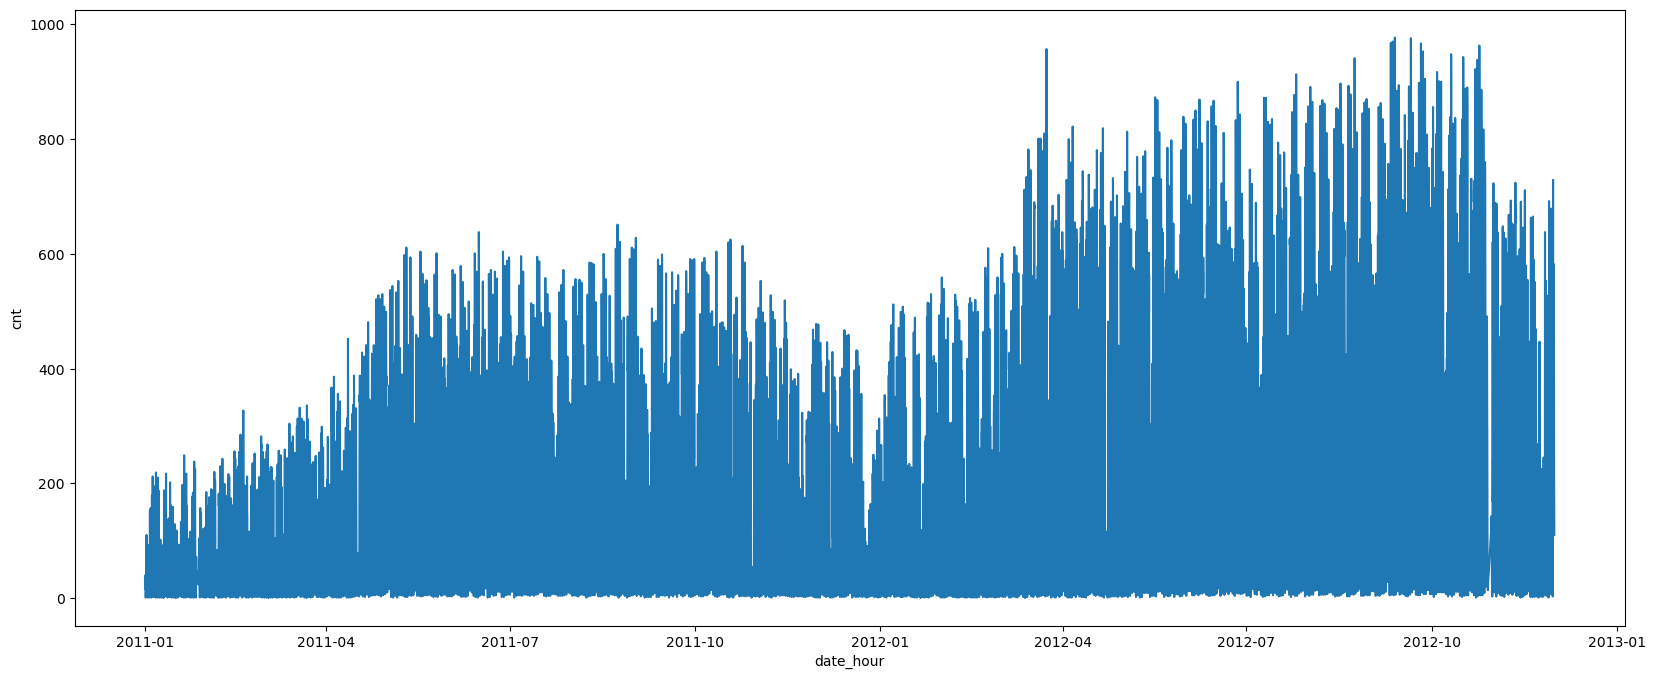

In [14]:
# Lineplot from 'date_hour' vs 'cnt'	
plt.figure(figsize=(20, 8))
sns.lineplot(data=train, x='date_hour', y='cnt')
plt.show()

In [15]:
# 'date_hour' to index
train_decomp = train.set_index('date_hour')
train_decomp = train_decomp['cnt']

In [16]:
# Splitting time to only retain three months of data
split_date = '2011-04-01 00:00:00'
train_decomp_split = train_decomp[:split_date]

In [17]:
# Decomposition of time series
def decompose_ts(series, period=None):


    series_decomp = sm.tsa.seasonal_decompose(series, period=period)
    trend = series_decomp.trend
    seasonal = series_decomp.seasonal
    resid = series_decomp.resid

    return trend, seasonal, resid

trend, seasonal, resid = decompose_ts(train_decomp, period=24)

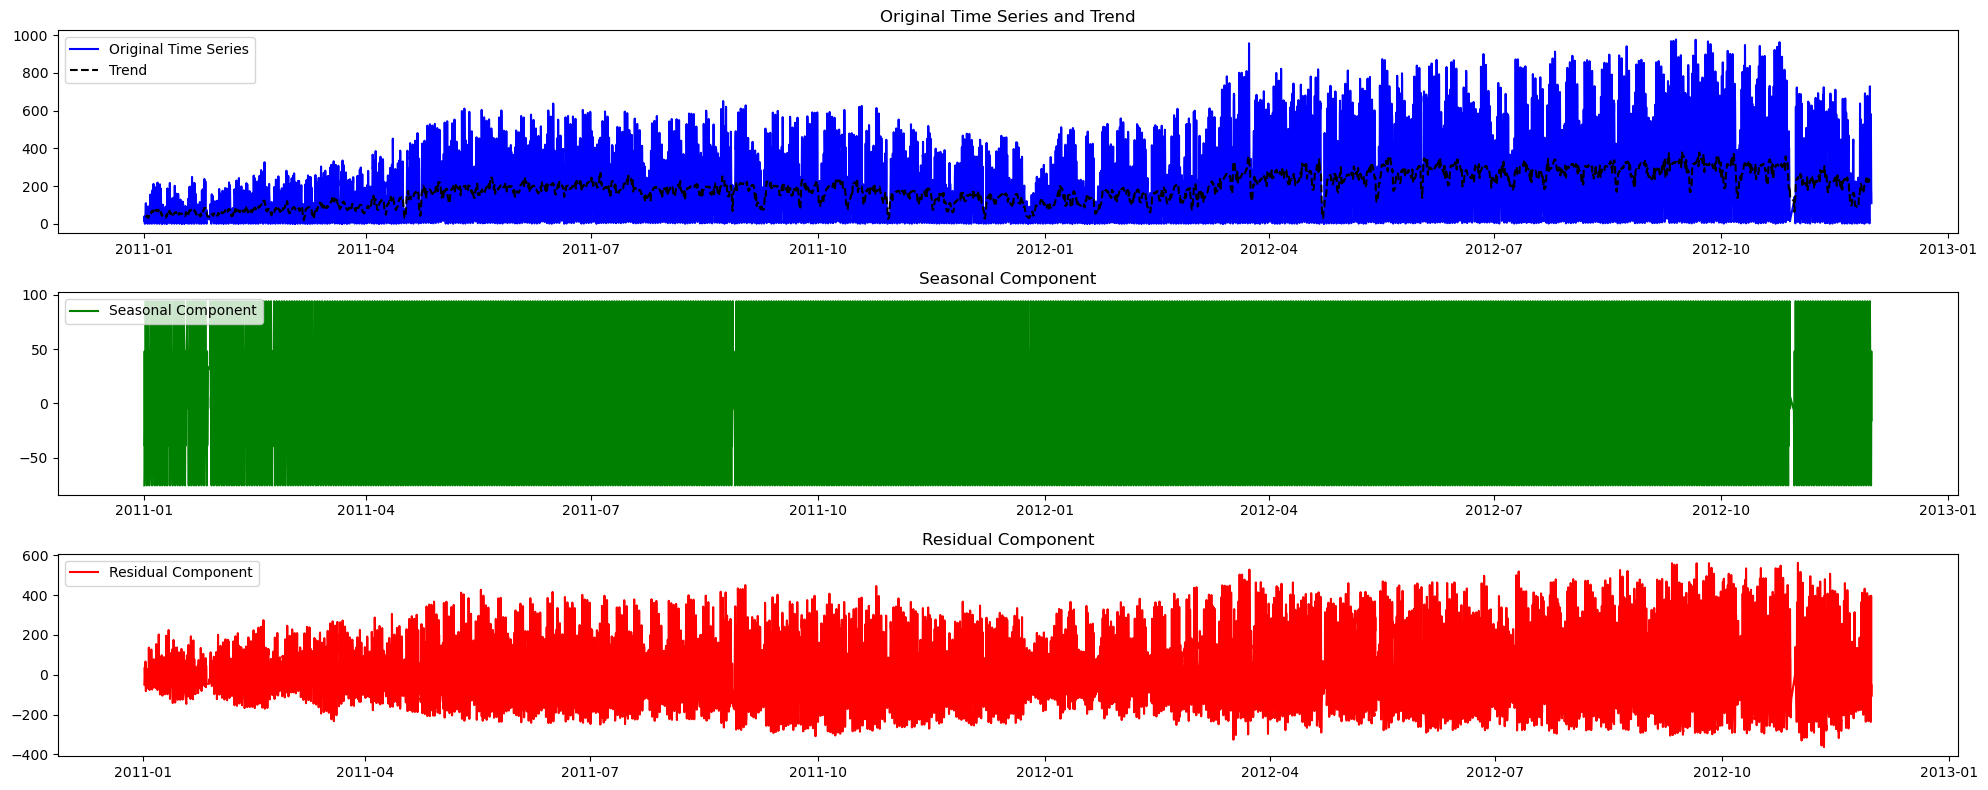

In [18]:
def plot_ts(series, trend, seasonal, residuals):
    """
    Plots the original time series, trend, seasonal, and residual components.

    Parameters:
        series (pandas.Series): Series with a DateTime index representing the original time series.
        trend (pandas.Series): Time series representing the trend component.
        seasonal (pandas.Series): Time series representing the seasonal component.
        residuals (pandas.Series): Time series representing the residual component.
    """

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 8))

    # Plot the original time series and trend
    axes[0].plot(series.index, series, color='blue', label='Original Time Series')
    axes[0].plot(series.index, trend, color='black', linestyle='dashed', label='Trend')
    axes[0].set_title('Original Time Series and Trend')
    axes[0].legend()

    # Plot the seasonal component
    axes[1].plot(series.index, seasonal, color='green', label='Seasonal Component')
    axes[1].set_title('Seasonal Component')
    axes[1].legend()

    # Plot the residual component
    axes[2].plot(series.index, residuals, color='red', label='Residual Component')
    axes[2].set_title('Residual Component')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

plot_ts(train_decomp, trend, seasonal, resid)


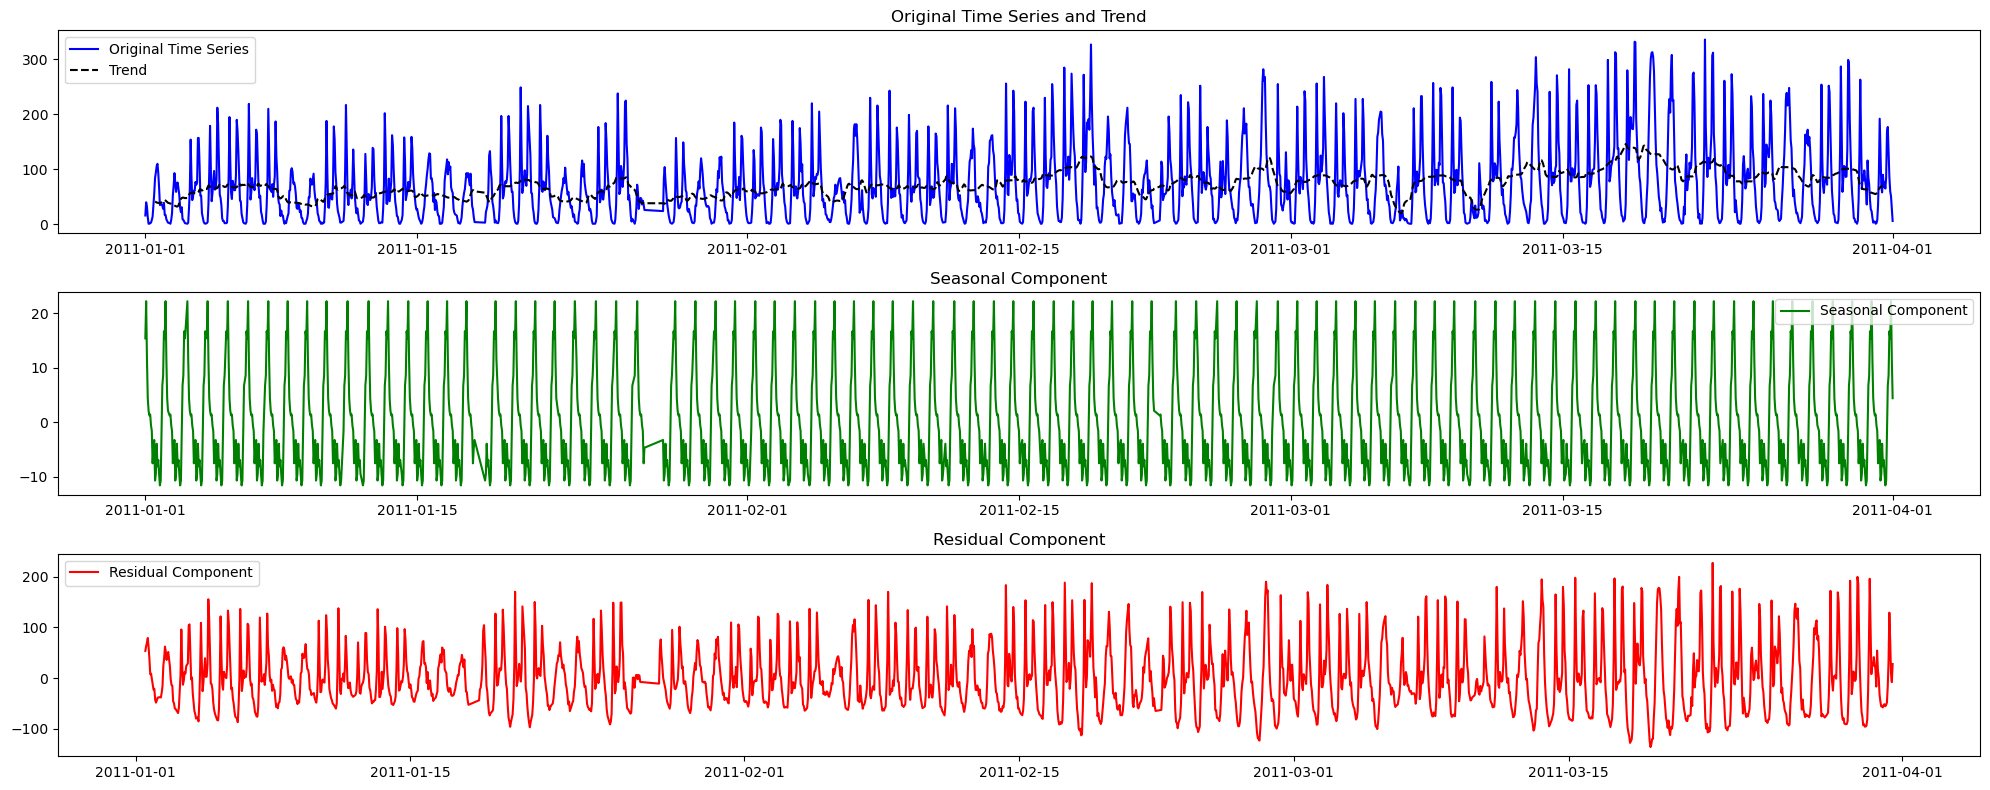

In [19]:
trend2, seasonal2, resid2 = decompose_ts(train_decomp_split, period=24)
plot_ts(train_decomp_split, trend2, seasonal2, resid2)

- Lineplot:

    - In deze grafiek is zowel een stijgende tend als seizoensgebondenheid in de data te zien.

- Decompose:

    Eerst wordt de gehele timeseries degecomposed. Doordat de dataset data bevat over een periode van twee jaar en dit per uur is gemeten, zijn er vrij veel datapunten. In de eerste decompose is enkel de trend goed af te lezen, maar de 'seasonal' grafiek is niet duidelijk. Daarom worden de eerste drie maanden van de data geselecteerd en vervolgens opnieuw gedecomposed om meer duidelijkheid over de seizoensgebondenheid te krijgen.
    
    - Trend: De trendgrafiek laat zien dat er een enigzins stijgende trend is in de data. Dit wordt in zowel de 'trend' grafiek van de decompose als in de orignele lineplot over twee jaar beide duidelijk. 
    - Seasonal: Er is duidelijk sprake van seizoensgebondenheid (per dag).  (Per dag)
    - Residual: Er is nog veel data dat nog niet verklaard is.

## 1.5 Stationariteit controleren en ACF/PACF

Aangezien een 'stationairy' dataset een belangrijke voorwaarde is voor 'ARIMA' timeseries modellen, wordt hieronder de Dickey-Fuller test uitgevoerd om dit te controleren.

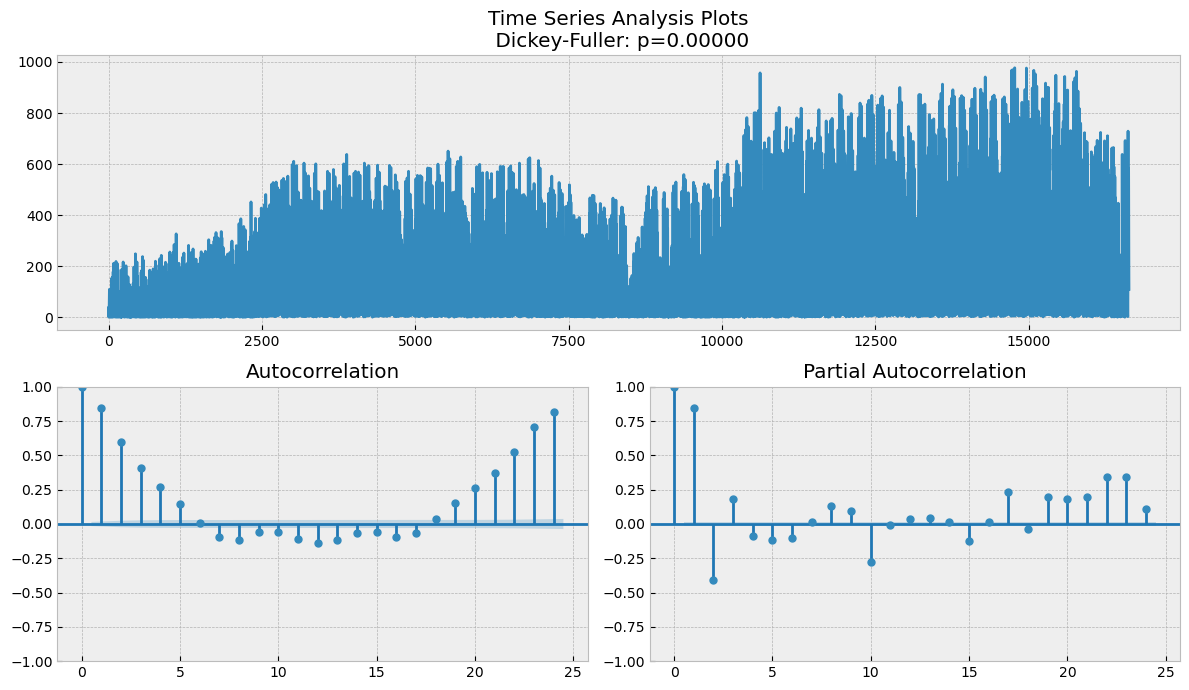

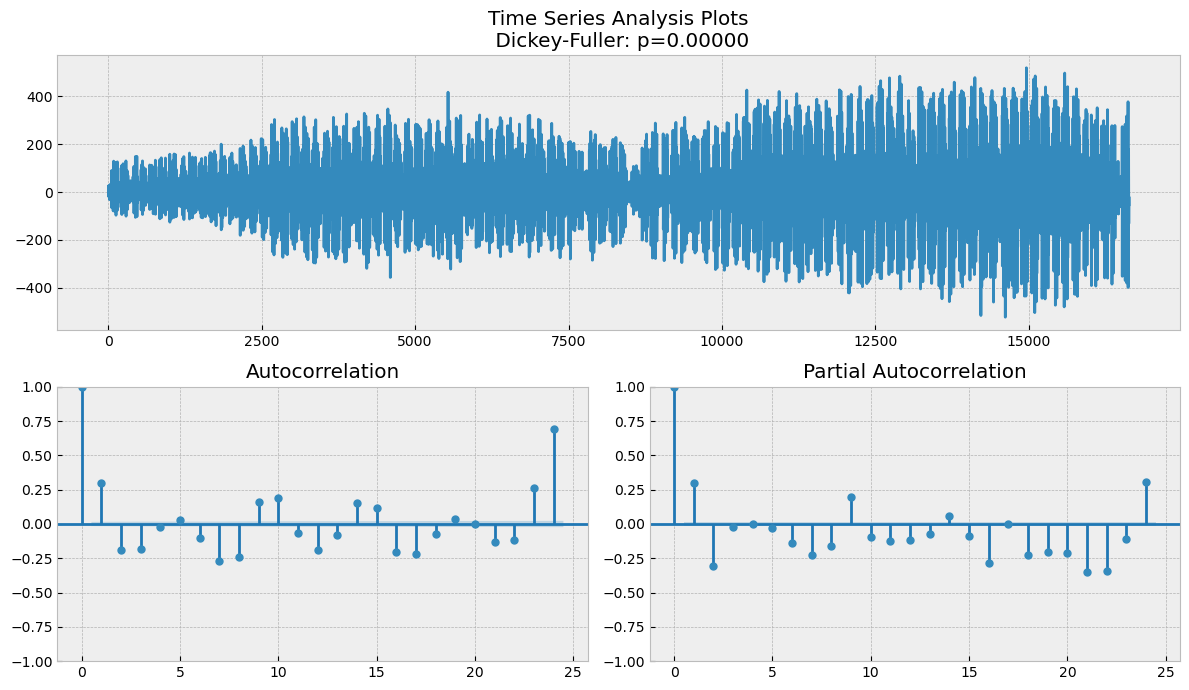

In [20]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
    Plot time series data along with its ACF and PACF.
    Parameters:
        y : array-like or pd.Series
        The time series data to plot.
        lags : int, optional
        Number of lags to include in the ACF and PACF plots. If None, will automatically determine the number of lags.
        figsize : tuple, optional
        The size of the figure for the plots. Default is (12, 7).
        style : str, optional
        The style to use for the plots. Default is 'bmh'.
    """    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(train['cnt'], lags=24)

# Take the first difference to remove to make the process stationary
data_diff = train['cnt'] - train['cnt'].shift(1)

tsplot(data_diff[1:], lags=24)

**Algemene uitleg ACF & PACF**

ACF:

- Hier wordt gekeken naar de correlatie tussen de huidige lag en alle voorgaande lags ten opzichte van Y. Dit wordt geplot in een grafiek wat ook duidelijk maakt of deze correlaties positief of negatief zijn.

PACF:

- Hier wordt enkel gekeken naar de correlatie tussen één eerdere lag ten opzichte van Y. Alle tussenliggende lags hebben dus geen invloed op de PACF.


**ACF & PACF op onze dataset**

ACF:

- In de grafiek is te zien dat de eerste vijf lags een relatief hoge correlatie hebben met de Y waarde. Dit neemt echt wel af. De dertien lags daarna tonen aan dat ze weer een hele lage correlatie hebben en vervolgens is er in de opvolgende zes lags weer een stijging in de correlatie. 

Dit zou kunnen aantonen dat er iets van een patroon in de data aanwezig is, ondanks het stationairy is.

PACF

- Hierin is te zien dat de eerste zeven lags een correlatie hebben met de Y waarde. Vanaf de 8e lag is een punt dat helemaal geen invloed meer heeft, dus daarna stoppen we ook met het verder kijken erna. 


Bij het gebruiken van de time series modellen zullen er dus zeven lags worden meegenomen in de parameters. 

Kis, A. (2024, 19 november). Understanding Autocorrelation and Partial Autocorrelation Functions (ACF and PACF). Medium. https://medium.com/@kis.andras.nandor/understanding-autocorrelation-and-partial-autocorrelation-functions-acf-and-pacf-2998e7e1bcb5

In [21]:
series = train['cnt']

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(series)

# Print the test results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")


ADF Statistic: -6.625164793721733
p-value: 5.901288668679013e-09
Critical Values:
   1%: -3.430744160906401
   5%: -2.8617142032973706
   10%: -2.5668627239973634


Uit de test komt een p-value van 5.90e-09, wat betekent dat de data stationairy zou moeten zijn. Kijkend naar de plots van de decompose ziet het er alleen niet stationairy uit. Dit komt doordat er een trend / seasonal component te zien is. Dit is raar, dus we weten niet of we het stationairy moeten maken.

## 1.6 Beschrijf wat de belangrijkste bevindingen zijn van de EDA

Er zijn veel inzichten gekomen uit de EDA. Hieronder zullen de belangrijkste kort worden toegelicht:

- In de visualisaties van toevoegde time series kolommen is te zien dat er duidelijke pieken zijn van verhuuraantallen om 8:00 en 18:00, maar ook dat er op de zondag aanzienlijk minder wordt verhuurd. Daarnaast zijn de aantal in de zomer een stuk hoger vergeleken die in de winter.

- In de correlatiematrix is naarboven gekomen dat 'temp' en 'atemp' een positieve invloed hebben op het aantal verhuuraantallen, terwijl 'hum' een negatieve correlatie ermee heeft. 

- De boxplots laten zien dat er geen duidelijk verband is tussen 'holiday' en de verhuuraantallen, maar dat er bij slechtere weeersomstandigheden ('weathersit'), wel een aanzienlijk dalende trend is. 

- Kijkend naar de histogrammen bevat de dataset geen rare / extreme outliers waar iets aan gedaan moet worden.

- Bij het decomposen van de data is het opgevallen dat er een licht stijgende lijn is in de verhuuraantallen over de twee jaar heen. Ook valt het op dat er een (dagelijks) periodiek patroon te zien is. 

- De Fourier-analyse heeft periodieke patronen geïdentificeerd, waarbij jaarlijkse, dagelijkse en de 12-uurlijkse de dominante frequenties waren.

- De P-value die uit de Dickey-Fuller test komt, toont aan dat de data stationair is, maar kijkend naar de grafieken valt het toch op dat er een duidelijke trend en seasonal component aanwezig was. Om zeker te zijn dat de data stationary is, voordat we gaan modelleren, is dit voor de zekerheid nog gedaan d.m.v. first order differencing.

- Er is een dalende en stijgende lijn in de ACF, wat aan kan tonen dat er toch patronen in de data aanwezig zijn. IN de PACF grafiek is er te zien dat de eerste twee lags de grootste invloed hebben op de Y waarde, waardoor er is besloten om die mee te nemen in de time series modellen.

# 2. Data-voorbereiding

## 2.1 Verwijder indien nodig niet relevante kolommen

In [22]:
train = train.drop(columns=['dayName', 'month'])
test = test.drop(columns=['dayName', 'month'])

In [23]:
display(train.head())
display(test.head())

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour,day,week,weekend
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,0,5,52,1
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,1,5,52,1
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2,5,52,1
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,3,5,52,1
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,4,5,52,1


,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,hour,day,week,weekend
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000,0,5,48,1
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000,1,5,48,1
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,2,5,48,1
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,3,5,48,1
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,4,5,48,1


### 2.1.1 Leg uit waarom deze wel of niet verwijderd zijn

- Dayname:

    Deze kolom wordt verwijderd aangezien het geen 'int' of 'float' is en het praktisch dezelfde data weergeeft als de 'day' kolom.

- Month:

    Deze kolom wordt verwijderd, omdat het hetzelfde laat zien als de 'week' kolom, maar de 'week' kolom heeft in dit geval meer waardes. Hierom hebben we besloten om deze van de twee te behouden. Door de 'month' kolom te verwijderen, zorgen we er ook voor dat er geen sprake is multicollineariteit. 

## 2.2 Vul eventuele missende waarden in of verwijder ze. Voor time series kan interpolatie een nuttige methode zijn.

In [24]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_hour   16637 non-null  datetime64[ns]
 1   holiday     16637 non-null  int64         
 2   weathersit  16637 non-null  int64         
 3   temp        16637 non-null  float64       
 4   atemp       16637 non-null  float64       
 5   hum         16637 non-null  float64       
 6   windspeed   16637 non-null  float64       
 7   cnt         16637 non-null  int64         
 8   hour        16637 non-null  int32         
 9   day         16637 non-null  int32         
 10  week        16637 non-null  UInt32        
 11  weekend     16637 non-null  int64         
dtypes: UInt32(1), datetime64[ns](1), float64(4), int32(2), int64(4)
memory usage: 1.3 MB


None

### 2.2.1 Leg uit waarom er voor wat gekozen is

Doordat er geen missende waardes zijn, hoeven hier ook geen aanpassingen voor worden gedaan.

## 2.3 Kijk of er outliers zijn

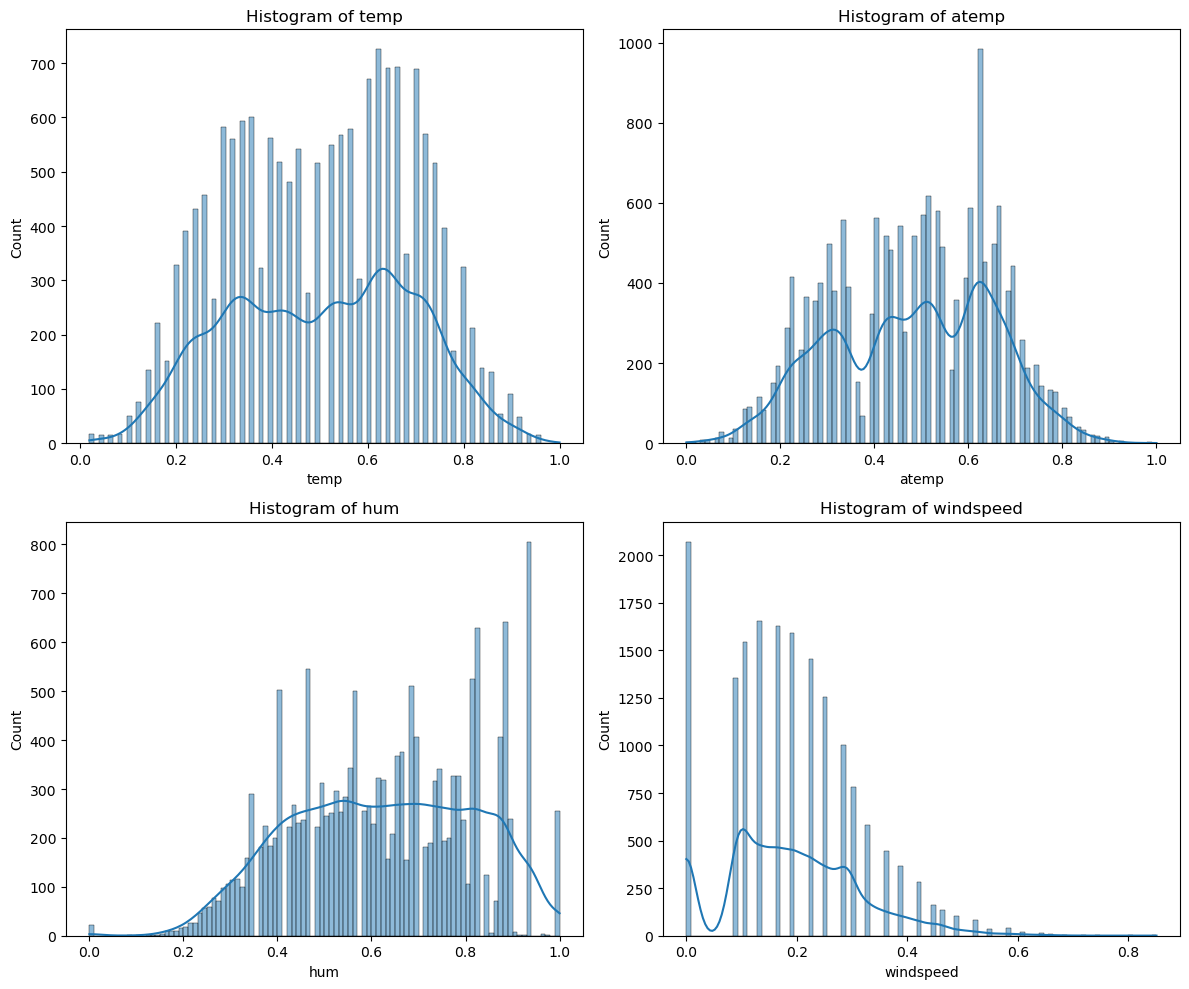

In [25]:
keys = ['temp', 'atemp', 'hum', 'windspeed']

fig, axes = plt.subplots(2,2 , figsize=(12, 10))

axes = axes.flatten()

for i, key in enumerate(keys):
    sns.histplot(data=train, x=key, bins=100, ax=axes[i], kde=True)
    axes[i].set_title(f'Histogram of {key}')

plt.tight_layout()
plt.show()


### 2.3.1 Verwijder of corrigeer deze indien nodig

Er is besloten om geen aanpassingen te doen aan de dataset.

### 2.3.2 Leg uit waarom deze keuze is gemaakt

- Temp:

    Temp is een normaal verdeling en heeft geen outliers.
    
- Atemp:

    Atemp is ook relatief normaal verdeeld en heeft geen extreme outliers.

- Hum:

    Hum is vrij left skewed, we zien geen grote outliers.

- Windspeed:

    Windspeed is duidelijk right skewed, het heeft een vrij lange staart maar neemt gelijdelijk af wat vrij reëel is.


Aangezien er niet extreem rare waardes in de dataset staan, is er dus besloten om geen aanpassingen te maken.


## 2.4 Schaal/normaliseer de data indien nodig

Er is enkel besloten om de week te min max normaliseren, aangezien het anders fout gaat in de testset (daar staat maar data van een paar weken).

In [26]:
scaler = MinMaxScaler()

train['week'] = scaler.fit_transform(train[['week']])
test['week'] = scaler.transform(test[['week']])

### 2.4.1 Leg uit waarom voor deze methode is gekozen

Hierboven wordt de 'week' kolom in train- en testset gescaled. De rest wordt niet gedaan.

Dit komt doordat de numerieke kolommen al zijn genormaliseerd en dus al op dezelfde schaal staan. Voor de 'weathersit', 'hour', 'day' en 'season' kolommen worden in beide de train- en testset dummies van gemaakt. Deze worden hierdoor veranderd naar booleans, wat ook betekent dat ze in dezelfde schaal staan. Ook zorgt dit ervoor dat categorien zoals de dagen van de week niet worden gezien als een grotere waarde van elkaar. Dag 2 in de week is niet 2 keer zo veel waard als dag 1.


## 2.5 Data sampling indien nodig

Er is besloten om niet te samplen. Zie reden hieronder:

### 2.5.1 Leg uit waarom dit wel/niet nodig is en welke methode wordt gebruikt

We over- of undersamplen de data niet, we hebben te maken met time series data en de continuïteit is hier erg belangrijk. Door het under samplen zouden we hier data uithalen en bij oversampelen zouden we hier neppe data toevoegen, beide zouden de continuïteit kunnen breken en zowel onze analysis als onze modellen in de weg kunnen zitten.

# 3. Time series feature engineering

## 3.1 Voeg tijdserie features toe aan de dataset

Er zijn eerder in het notebook timeserie features toegevoegd aan de dataset. Dit is in de EDA gedaan, aangezien er tijdens de EDA ook grafieken zijn geplot aan de hand van deze features om er een beter inzicht in te krijgen. Kijk hiervoor in hoofdstuk 1.2.

## 3.2 Onderzoek wat de de invloed is van deze features, samen met de andere features, op de voorspellingen

### 3.2.1 Onderzoek naar seizoenspatronen met Fourier analyse

Peaks found at [   2  692  694 1387]


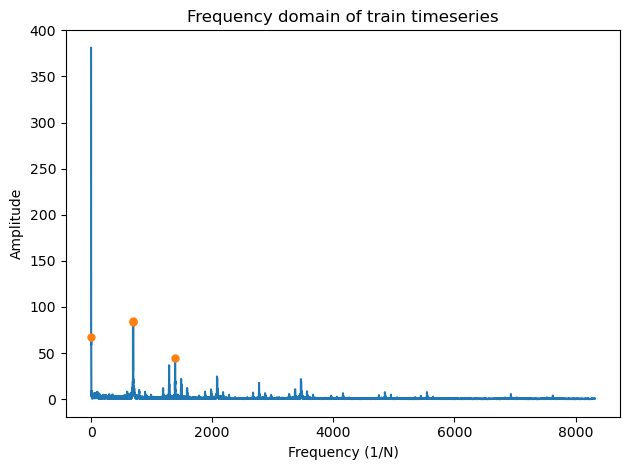

In [27]:
# Calculate the number of samples in the timeseries
N = len(train)

# Compute the Fourier transform of the timeseries
train_ft = np.fft.fft(train['cnt'])

# Compute the magnitude of the frequencies
magnitude = 2.0/N * np.abs(train_ft[:N//2])

peaks, _ = find_peaks(magnitude, height=40)

print(f"Peaks found at {peaks}")

# Plot the constituent frequencies
plt.plot(magnitude)
plt.xlabel('Frequency (1/N)')
plt.ylabel('Amplitude')
plt.title("Frequency domain of train timeseries")

plt.plot(peaks, magnitude[peaks], ".", markersize=10)

#plt.xlim(1250, 1500)
plt.tight_layout()
plt.show()

#### 3.2.2 Leg uit hoe het werkt en wat er is gevonden

De pieken in de frequenties staan op 2, 692/694 en 1387.

Formule periode is totale lengte / frequentie.

De periodes die hierbij horen zijn:

Frequentie 2: 16637/2 = 8318.5 uur (bijna één jaar).

Frequentie 692/694: 16637/692 = (ongeveer) 24 uur.

Frequentie 1387: 16637 / 1387 = 12 uur.

**Bevindingen**

Door het toe te passen van de fourier analyse op onze data zien we een duidelijk periodiek patroon terugkomen, deze vallen op de frequenties de gelijkstaan aan jaarlijks (freq ~2), dagelijks (freq ~692), 12 uurlijks (freq ~1387). Dit zijn dus ook de dominante frequenties in de grafiek.


**Algemene uitleg werking fourier analyse**

Bij een Fourieranalyse wordt een wiskunde techniek toegepast die een time series omzet van het 'tijdsdomein' naar het 'frequentiedomein'. Dit houdt in dat een complexe time series wordt ontleedt in de samenstellende onderliggende periodieke signalen. 

Het voornaamste idee achter Fourier-analyse is dat elke complexe tijdsreeks kan worden gezien als een som van eenvoudige periodieke signalen, zoals sinus- en cosinusgolven, met verschillende frequenties, amplitudes en fasen. Door deze techniek toe te passen, wordt het mogelijk om te begrijpen uit welke frequenties het oorspronkelijke signaal bestaat en hoe sterk deze frequenties aanwezig zijn.

Frequentie: hoe vaak een bepaald periodiek signaal zich herhaalt binnen een bepaalde periode.
Amplitudespectrum: de sterke van de verschillende frequenties.
Fase: Verschuiving van de golf in de tijd.


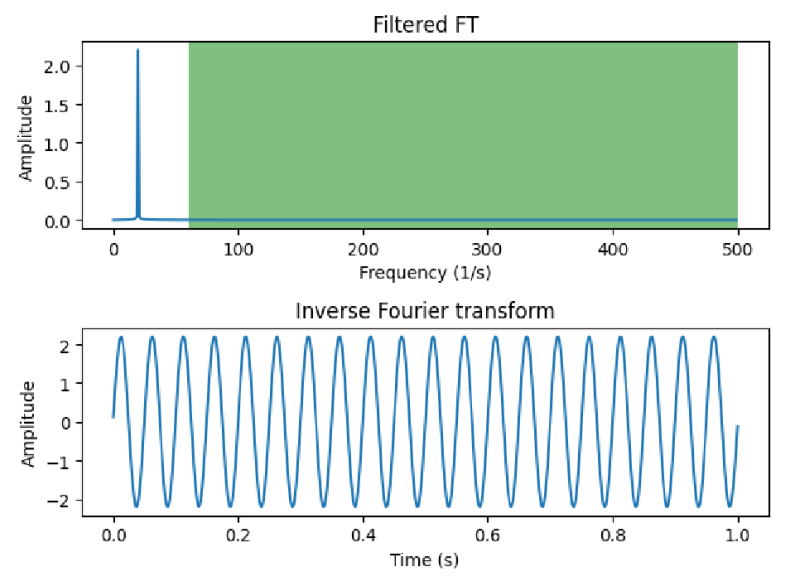


Het biedt verschillende inzichten:
- Het laat zien welke cyclische patronen er in de data zitten (wekelijkse, maandelijkse, jaarlijkse trend etc.).
- Aan de hand van de amplitude kan je zien welke frequenties het meest dominant zijn in de timeseries.
- Het geeft mogelijkheden tot een trendanalyse. Als een signaal wordt gedomineerd door lage frequenties, betekent dat dat er langzame trends zijn. Hoge frequenties geven aan dat er snelle fluctuaties zijn.

Om een beter model te creëren is er ook nog een 'inverse fourier-transformatie'.  Hiermee kan je bepaalde (niet relevante) frequenties uit de timeseries verwijderen. 

Er zijn verschillende manieren om dit te doen:
- Low-pass filter -> hiermee behoudt je lage frequenties (en verwijder je juist hoge frequenties) om snelle, ongewenste fluctuaties te verwijderen en langzame trends te behouden.

![Low Pass Filter](low_pass.png)


- High-pass filter -> hiermee behoudt je hoge frequenties (en verwijder je juist de lage frequenties) om snelle veranderingen in het signaal te behouden en langzame trends te verwijderen.
  
![High Pass Filter](high_pass.png)


- Bandstop filter - > dit onderdrukt een bepaalde frequentieband in de grafiek, terwijl het de rest van de frequenties behoudt.

![Bandstop Filter](bandstop.png)


- Bandpass filter -> dit laat juist een bepaalde frequentieband in de grafiek zien, terwijl het zowel lage als hoge frequenties verwijderd.

![Bandpass Filter](bandpass.png)

- Noise filter -> dit verwijdert de ruis in een signaal.

![Noise Filter](noise_filter.png)

week 10 Les Vikram Mark Radhakrishnan (n.d.). https://brightspace.hhs.nl/content/enforced/102168-ADSAI-MACHI-23_2024_FALL_1/Lecture%20-%20Timeseries%20analyse%202.pdf

An interactive guide to the Fourier transform – BetterExplained. (z.d.). https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/

### 3.2.3 Onderzoek naar trends

In [28]:
temp_X = train.drop(columns=['cnt'])
temp_y = train['cnt']

In [29]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(temp_X, temp_y, test_size=19*24, shuffle=False, random_state=456)

In [30]:
for order in range(1, 6):
    dp = DeterministicProcess(index=y_train_t.index, constant=False, order=order, drop=True)
    X_train_t = dp.in_sample()
    X_test_t = dp.out_of_sample(steps=len(y_test_t))
    model = LinearRegression()
    model.fit(X_train_t, y_train_t)
    y_pred = model.predict(X_train_t)
    y_fore = model.predict(X_test_t)
    rmse_train = np.sqrt(mean_squared_error(y_train_t, y_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test_t, y_fore))
    print('order: ', order)
    print('RMSE Train:', rmse_train)
    print('RMSE Test:', rmse_test)
    print('Coefficients:', model.coef_)

order:  1
RMSE Train: 172.1301778615243
RMSE Test: 199.3896467778171
Coefficients: [0.01283752]
order:  2
RMSE Train: 172.08925321070743
RMSE Test: 204.12228540109373
Coefficients: [9.72532173e-03 1.92324992e-07]
order:  3
RMSE Train: 171.66519162223997
RMSE Test: 226.60230657391344
Coefficients: [ 3.34188996e-02 -3.46804544e-06  1.50800084e-10]
order:  4
RMSE Train: 169.36038952654042
RMSE Test: 176.1846998237374
Coefficients: [ 1.37405394e-01 -3.23832336e-05  2.93032382e-09 -8.58831913e-14]
order:  5
RMSE Train: 169.36038952654042
RMSE Test: 176.1846998237374
Coefficients: [ 1.37405394e-01 -3.23832336e-05  2.93032382e-09 -8.58831913e-14]


In [31]:
# Calculating order 1 for trainset
dp_train = DeterministicProcess(index=train.index, constant=False, order=1, drop=True)
trend_train = dp_train.in_sample()

# Adding order 1 to trainset
train = pd.concat([train, trend_train], axis=1)

# Finding last value of trainset trend
last_trend_value = trend_train.iloc[-1, 0]

# Calculating order 1 for testset
dp_test = DeterministicProcess(index=test.index, constant=False, order=1, drop=True)
trend_test_raw = dp_test.in_sample()
trend_test = trend_test_raw + last_trend_value

# Adding order 1 to testset
test = pd.concat([test, trend_test], axis=1)

display(train.tail())
display(test.head())



,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour,day,week,weekend,trend
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,19,4,0.921569,0,16633.0
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,20,4,0.921569,0,16634.0
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,21,4,0.921569,0,16635.0
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163,22,4,0.921569,0,16636.0
16636,2012-11-30 23:00:00,0,2,0.30,0.3182,0.75,0.0896,110,23,4,0.921569,0,16637.0


,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,hour,day,week,weekend,trend
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000,0,5,0.921569,1,16638.0
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000,1,5,0.921569,1,16639.0
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,2,5,0.921569,1,16640.0
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,3,5,0.921569,1,16641.0
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,4,5,0.921569,1,16642.0


Hier wordt de trend voor beide de train- en testset toegevoegd op een manier waarop de trend doorloopt in de testset vanaf het punt waar die in de trainset is gestopt. Hierdoor start de trend dus niet weer opnieuw bij 1.

#### 3.2.4 Leg uit hoe het werkt en wat er is gevonden

Als je kijkt naar de testset RMSE scores, dan zou het gebruiken van order 4 het best zijn. Uit de uitleg eerder dit jaar is gebleken dat order 1 en 2 voornamelijk voorkomen, terwijl order 3 en 4 vrijwel nooit gebruikt worden. Ook is er te zien dat de RMSE score verslechterd bij elke hogere order en dan ineens een heel stuk wordt verbeterd bij order 4. Dit is een raar patroon wat we niet kunnen verklaren. Daarnaast betekent order 4 dat het zo slecht generaliseerd dat het niet waard is om te gebruiken, dit zorgt voor extreme waardes waar het model niet goed op gefit kan worden. Hierom is er besloten om dan toch order 1 te gebruiken, aangezien dit degene is met de beste RMSE score van de drie. 

### 3.2.5 Onderzoek naar cycli en autocorrelatie

Dit is beschreven in hoofdstuk 1.5 in combinatie met stationariteit. Dit zal hier dus niet nogmaals worden uitgelegd.

### 3.2.7 Onderzoek naar andere tijdsgebaseerde features

*denk hier bijvoorbeeld aan:

- lags: Vertragingen in de tijd (bijv. de waarde van vorige dag).
- Rolling statistics: Gemiddelden of varianties over een bepaald venster.
- Datumgerelateerde features: Dag van de week, maand, seizoenen, feestdagen, enz.

### Cyclische representatie

Hier worden de veschillende cyclische kenmerken aan de hand van de periodes toegevoegd aan beide de train- en testset dataframes.

In [32]:
# Cyclische kenmerken toevoegen
def add_cyclic_features(df, time_col, periods, prefix="hour"):
    """
    Adds cyclic features to a DataFrame based on a specified time column and periods.
    Parameters:
        df (pd.DataFrame): The input DataFrame containing the time column.
        time_col (str): The name of the column in the DataFrame that contains the time values.
        periods (list): A list of periods to create cyclic features for (e.g., [24, 12] for daily and half-daily cycles).
        prefix (str, optional): A prefix for the new cyclic feature columns. Default is "hour".
        Returns:
            pd.DataFrame: The DataFrame with added cyclic features.
    """
    
    for period in periods:
        sin_col_name = f"sin_{prefix}_{period}"
        cos_col_name = f"cos_{prefix}_{period}"
        
        df[sin_col_name] = np.sin(2 * np.pi * df[time_col] / period)
        df[cos_col_name] = np.cos(2 * np.pi * df[time_col] / period)
    
    return df

train = add_cyclic_features(train, time_col="hour", periods=[24, 12, 8318], prefix="hour")
display(train.head())

test = add_cyclic_features(test, time_col="hour", periods=[24, 12, 8318], prefix="hour")
display(test.head())


,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour,day,week,weekend,trend,sin_hour_24,cos_hour_24,sin_hour_12,cos_hour_12,sin_hour_8318,cos_hour_8318
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,0,5,1.0,1,1.0,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.000000
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,1,5,1.0,1,2.0,0.258819,0.965926,0.500000,8.660254e-01,0.000755,1.000000
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2,5,1.0,1,3.0,0.500000,0.866025,0.866025,5.000000e-01,0.001511,0.999999
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,3,5,1.0,1,4.0,0.707107,0.707107,1.000000,6.123234e-17,0.002266,0.999997
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,4,5,1.0,1,5.0,0.866025,0.500000,0.866025,-5.000000e-01,0.003021,0.999995


,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,hour,day,week,weekend,trend,sin_hour_24,cos_hour_24,sin_hour_12,cos_hour_12,sin_hour_8318,cos_hour_8318
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000,0,5,0.921569,1,16638.0,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.000000
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000,1,5,0.921569,1,16639.0,0.258819,0.965926,0.500000,8.660254e-01,0.000755,1.000000
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,2,5,0.921569,1,16640.0,0.500000,0.866025,0.866025,5.000000e-01,0.001511,0.999999
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,3,5,0.921569,1,16641.0,0.707107,0.707107,1.000000,6.123234e-17,0.002266,0.999997
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,4,5,0.921569,1,16642.0,0.866025,0.500000,0.866025,-5.000000e-01,0.003021,0.999995


**Cyclische representatie toevoegen**

We hebben hier de Cyclische representatie toegevoegd op de top 3 frequenties uit de fourier analyse. Dis zijn de (ongeveer) jaarlijkse, dagelijkse en 12-uurlijkse frequenties (zie hoofdstuk 3.2.2.).

Bij tijdreeksanalyse en -modellering is het vaak cruciaal om de herhalende patronen (cycli) in de data te herkennen en effectief te gebruiken. Veel tijdsgerelateerde kenmerken, zoals dagen van de week, maanden van het jaar of uren van de dag, hebben een cyclische aard. Cyclische representaties, gebaseerd op sinus en cosinus, maken het mogelijk om deze patronen op een consistente manier vast te leggen.

## 3.3 Dummies


Hieronder worden de dummies aangemaakt, deze worden gebruikt omdat bijvoorbeeld uur 24 in de dag niet 2 keer zoveel waard is als uur 12 etc. 

In [33]:
# turning date_hour into the index to work with the time series
test.set_index('date_hour', inplace=True)
train.set_index('date_hour', inplace=True)

In [34]:
columns_to_dummy = ['weathersit', 'day', 'hour']

# Apply get_dummies to these columns
test = pd.get_dummies(test, columns=columns_to_dummy)
train = pd.get_dummies(train, columns=columns_to_dummy)

# Now 'test' will contain the dummy variables
display(train.info())
display(test.info())



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16637 entries, 2011-01-01 00:00:00 to 2012-11-30 23:00:00
Data columns (total 50 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   holiday        16637 non-null  int64  
 1   temp           16637 non-null  float64
 2   atemp          16637 non-null  float64
 3   hum            16637 non-null  float64
 4   windspeed      16637 non-null  float64
 5   cnt            16637 non-null  int64  
 6   week           16637 non-null  float64
 7   weekend        16637 non-null  int64  
 8   trend          16637 non-null  float64
 9   sin_hour_24    16637 non-null  float64
 10  cos_hour_24    16637 non-null  float64
 11  sin_hour_12    16637 non-null  float64
 12  cos_hour_12    16637 non-null  float64
 13  sin_hour_8318  16637 non-null  float64
 14  cos_hour_8318  16637 non-null  float64
 15  weathersit_1   16637 non-null  bool   
 16  weathersit_2   16637 non-null  bool   
 17  weathersit_3   

None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 456 entries, 2012-12-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 48 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   holiday        456 non-null    int64  
 1   temp           456 non-null    float64
 2   atemp          456 non-null    float64
 3   hum            456 non-null    float64
 4   windspeed      456 non-null    float64
 5   week           456 non-null    float64
 6   weekend        456 non-null    int64  
 7   trend          456 non-null    float64
 8   sin_hour_24    456 non-null    float64
 9   cos_hour_24    456 non-null    float64
 10  sin_hour_12    456 non-null    float64
 11  cos_hour_12    456 non-null    float64
 12  sin_hour_8318  456 non-null    float64
 13  cos_hour_8318  456 non-null    float64
 14  weathersit_1   456 non-null    bool   
 15  weathersit_2   456 non-null    bool   
 16  weathersit_3   456 non-null    bool   
 17  day_0          45

None

We zorgen dat de testset alle kolommen heeft die de trainset ook heeft, extras worden toegevoegd en gevuld met 0 aangezien dit dummies zijn van waardes die niet in de testset voorkomen.

In [35]:
# Identify columns that are in train but not in test, except 'cnt'
missing_cols = set(train.columns) - set(test.columns) - {'cnt'}

# Add the missing columns to the test set and fill with zeros
for col in missing_cols:
    test[col] = 0
    
# Display the updated test set
display(test.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 456 entries, 2012-12-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 49 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   holiday        456 non-null    int64  
 1   temp           456 non-null    float64
 2   atemp          456 non-null    float64
 3   hum            456 non-null    float64
 4   windspeed      456 non-null    float64
 5   week           456 non-null    float64
 6   weekend        456 non-null    int64  
 7   trend          456 non-null    float64
 8   sin_hour_24    456 non-null    float64
 9   cos_hour_24    456 non-null    float64
 10  sin_hour_12    456 non-null    float64
 11  cos_hour_12    456 non-null    float64
 12  sin_hour_8318  456 non-null    float64
 13  cos_hour_8318  456 non-null    float64
 14  weathersit_1   456 non-null    bool   
 15  weathersit_2   456 non-null    bool   
 16  weathersit_3   456 non-null    bool   
 17  day_0          45

None

## 3.4 Maak duidelijk hoe jullie tot de uiteindelijke keuze voor de features en model(len) zijn gekomen. Wat is er allemaal geprobeerd?

Keuze features:


- Standaard timeseries kolommen (hour, day, week, weekend, season, weekend)

Aan het begin zijn er een aantal standaard timeseries kolommen toegevoegd als features (zie hierboven). Deze zijn toegevoegd om ten eerst een beter inzicht in de data te krijgen, maar ook om uiteindelijk weer andere features mee te maken (zoals de sin / cos van deze kolommen)

- Trend

Door te kijken naar de originele grafiek zijn we erachter gekomen dat er een stijgende trend over de jaren in de data zit. Ook is er uit de DeterministicProcess functie gekomen dat order 1 het beste paste bij onze data. Door deze twee redenen is er besloten om een trend van order 1 als feature toe te voegen. Een trend is een patroon in de data dat de beweging van een reeks naar relatief hogere of lagere waarden over een lange perioden laat zien, oftewel een trend wordt waargenomen als er een stijging of daling plaatsvindt in de data. Ze zijn er maar voor een tijdje en herhalen zich niet. Dit is de formule om de trend te berekenen als het gekozen model LinearRegression is: y_t = b_0 + (b_1 * t).

    - y_t is de variabel
    - b_0 is een constante waarde
    - b_1 is de coëfficiënt
    - t is de tijd


bron voor formule: Interpret all statistics and graphs for Trend Analysis - Minitab. (z.d.). (C) Minitab, LLC. All Rights Reserved. 2024. https://support.minitab.com/en-us/minitab/help-and-how-to/statistical-modeling/time-series/how-to/trend-analysis/interpret-the-results/all-statistics-and-graphs/

bron voor uitleg: GeeksforGeeks. (2024, 20 maart). What is a trend in time series? GeeksforGeeks. https://www.geeksforgeeks.org/what-is-a-trend-in-time-series/

- Standaard timeseries kolommen (hour, day, week, weekend, season, weekend)<br>
<br>
Aan het begin zijn er een aantal standaard timeseries kolommen toegevoegd als features (zie hierboven). Deze zijn toegevoegd om ten eerst een beter inzicht in de data te krijgen, maar ook om uiteindelijk weer andere features mee te maken (zoals de sin / cos van deze kolommen)

- Trend <br>
<br>
Door te kijken naar de originele grafiek zijn we erachter gekomen dat er een stijgende trend over de jaren in de data zit. Ook is er uit de DeterministicProcess functie gekomen dat order 1 het beste paste bij onze data. Door deze twee redenen is er besloten om een trend van order 1 als feature toe te voegen.

- Sinus + Cosinus <br>
<br>
In de Fourier Analyse is naarboven gekomen dat er drie significante frequenties waren. Dit waren de jaarlijkse, dagelijkse en 12-uurlijke periode. Doordat dit de drie dominante frequenties waren, zijn er voor deze drie frequenties sinus / cosinus representaties toegevoged aan de dataset. 

- Lags eventueel<br>
<br>
Aan het algemene dataframe worden er geen lags van kolommen toegevoegd. Enkel in het SARIMA model wordt er gebruik gemaakt van lags, maar deze worden in de parameter aangegeven.

Keuze modellen:

- Lineair Regression<br>
<br>
Lineaire regressie is een eenvoudig model om te kijken of er een lineaire relatie is tussen de tijd en target. Ook kan het goed met trends en seasonal data omgaan. Daarnaast is het ook een goed model om als basis mee te starten. 


- Decision Tree Regressor<br>
<br>
Deze is gekozen zodat we ook een model hebben dat om kan gaan met niet lineaire relaties. We hebben een vrij ingewikkelde dataset met verschillende patronen, waardoor dit een goed model kan zijn.


- Random Forest Regressor<br>
<br>
Dit is ensemble dat gebruik maakt van verschillende decision trees, dus het is hier eigenlijk een verbetere versie van. Ook heeft het een relatief korte trainingstijd in tegenstelling tot ensembles die sequentieel worden getraind, waardoor het geschikter is voor ons.

- KNeighborsRegressor<br>
<br>
Het is een flexibel model dat herhalende periodieke patronen in de data goed kan herkennen. Ook maakt het geen aannames over lineaire of niet-lineaire relaties, wat goed zou kunnen zijn voor om voorspellingen mee te maken voor timeseries modellen.

- XGBRegressor<br>
<br>
Dit model kan net wat beter werken dan andere ensemble modellen. Het wordt namelijk sequentieel getrain, waardoor dit wel langer de tijd kost, maar zo leert het van de fouten van eerdere trees. Over het algemeen is dit een heel krachtig model, dus is er besloten om ook hiervan gebruik te maken.


- SARIMAX <br>
<br>
Dit model is gekozen, aangezien dit een randvoorwaarde van het project is. Ook is het natuurlijk een timeseries model, wat goed zou moeten werken op een timeseries dataset. SARIMA heeft ook meerdere ingebouwde parameters dat de mogelijkheid biedt om met onder andere lags, seasonal componenen etc. te gaan voorspellen. Ook neemt het eerdere fouten mee, om zichzelf hiermee te verbeteren.

- Prophet <br>
<br>
Prophet is gekozen vanwege het makkelijke gebruik en veel automatische features, zo kan het bijvoorbeeld dagelijks, maandelijkse en meer seizoensgebondenheid vinden en gebruiken in het model. 

- Hybride model <br>
<br>
Een hybride model gebruiken we zodat we 2 modellen kunnen gebruiken om elkaars zwakke punten aan te vullen, zo hopen we een nog sterker model te vormen.

<br>

**Gebruikte bronnen staan later in het notebook per model aangegeven**

# 4. Modelling

## 4.1 Time series combineren met normale features (x5)

In [36]:
models_dict = {'lr': LinearRegression(),
               'dt': DecisionTreeRegressor(),
               'rf': RandomForestRegressor(max_depth=10, random_state=42, n_jobs=-1),
               'knn': KNeighborsRegressor(),
               'xgb': XGBRegressor(),
               }

In [37]:
class RegressionModels:
    """
    A class used to represent various regression models and their operations.
    Attributes
    ----------
    data : pandas.DataFrame
        The input data for the regression models.
    X : pandas.DataFrame
        The feature matrix after preprocessing.
    y : pandas.DataFrame
        The target variable.
    X_train : pandas.DataFrame
        The training set features.
    X_test : pandas.DataFrame
        The test set features.
    y_train : pandas.DataFrame
        The training set target.
    y_test : pandas.DataFrame
        The test set target.
    models_dict_tune : dict
        Dictionary containing models and their parameter grids for tuning.
    results : dict
        Dictionary to store the results of the parameter tuning.
    best_model : str
        The name of the best model after tuning.
    best_params : dict
        The best parameters for the best model.
    best_score : float
        The best score achieved by the best model.
    fi : dict
        Dictionary to store feature importances for models that have this attribute.
    models_dict : dict
        Dictionary containing models to be used for prediction.
    Methods
    -------
    __init__(data, target, shuffle=True, test_size=0.2, random_state=42)
        Initializes the RegressionModels class with data, target, and other optional parameters.
    tune_params(n_splits, models_dict_tune)
        Tunes the parameters of the models using TimeSeriesSplit cross-validation.
    predict(models=models_dict)
        Fits the models on the training data and makes predictions on the test data.
    show_feature_importances()
        Displays the feature importances for models that have this attribute.
    """
    def __init__(self, data, target, shuffle=True, test_size=0.2, random_state=42):
        self.data = data             
        self.X = self.data.drop(target, axis=1)
        self.y = self.data[[target]]        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y,
                                                                                test_size=test_size, shuffle=shuffle, 
                                                                                random_state=random_state)
        
    def tune_params(self, n_splits, models_dict_tune):
        self.models_dict_tune = models_dict_tune
        self.results = {}
        self.best_model = None
        self.best_params = None
        self.best_score = float('inf')
        kf = TimeSeriesSplit(n_splits=n_splits)
        for model in models_dict_tune.items():
            model_cv = GridSearchCV(estimator=model[1][0], param_grid=model[1][1], cv=kf, n_jobs=-1, scoring='neg_root_mean_squared_error')
            model_cv.fit(self.X_train, self.y_train)
            self.results[model[0]] = [model_cv.best_params_, -model_cv.best_score_]
            print(model[0], self.results[model[0]])
            if -model_cv.best_score_ < self.best_score:
                self.best_score = -model_cv.best_score_
                self.best_model = model[0]
                self.best_params = model_cv.best_params_  
    
    def predict(self, models=models_dict):
        # dict to store feature importances
        self.fi = {}
        self.models_dict = models
        for model in self.models_dict.items():            
            model[1].fit(self.X_train, self.y_train)
            self.y_train_pred = model[1].predict(self.X_train)
            self.y_test_pred = model[1].predict(self.X_test)
            train_rmse = np.sqrt(mean_squared_error(self.y_train, self.y_train_pred))
            test_rmse = np.sqrt(mean_squared_error(self.y_test, self.y_test_pred))
            print(f'train RMSE {model[0]}: {train_rmse}')
            print(f'test RMSE {model[0]}: {test_rmse}')
            # only if attribute exists
            if hasattr(model[1], 'feature_importances_'):
                self.fi[model[0]] = model[1].feature_importances_

    def show_feature_importances(self):
        for fi in self.fi.items():
            feature_importance = pd.DataFrame(fi[1])
            cols = pd.DataFrame(self.X_train.columns)
            df_fi = pd.concat([cols, feature_importance], axis=1)
            df_fi.columns = ['feature', 'importance']
            df_fi.sort_values('importance', ascending=True, inplace=True)
            # Stel de hoogte van de figuur in afhankelijk van het aantal features
            num_features = len(df_fi)
            fig_height = max(6, num_features * 0.3)  # Dynamische hoogte, minimaal 6

            # Plot de grafiek
            df_fi.plot(
                kind='barh',
                x='feature',
                y='importance',
                title=fi[0],
                figsize=(10, fig_height)  # Breedte=10, hoogte variabel
            )
            plt.tight_layout()  # Zorg dat alles goed past
            plt.show()

In [38]:
data = RegressionModels(data=train, target='cnt', shuffle=False, test_size=19*24)

## 4.1.1 RMSE before and after combing features

train RMSE lr: 102.94127204099708
test RMSE lr: 108.64912567425392
train RMSE dt: 0.0
test RMSE dt: 98.16589967829522
train RMSE rf: 42.36060354495789
test RMSE rf: 104.17292548777894
train RMSE knn: 69.86551805921656
test RMSE knn: 177.165403438252
train RMSE xgb: 24.1910479646579
test RMSE xgb: 65.42006587311653


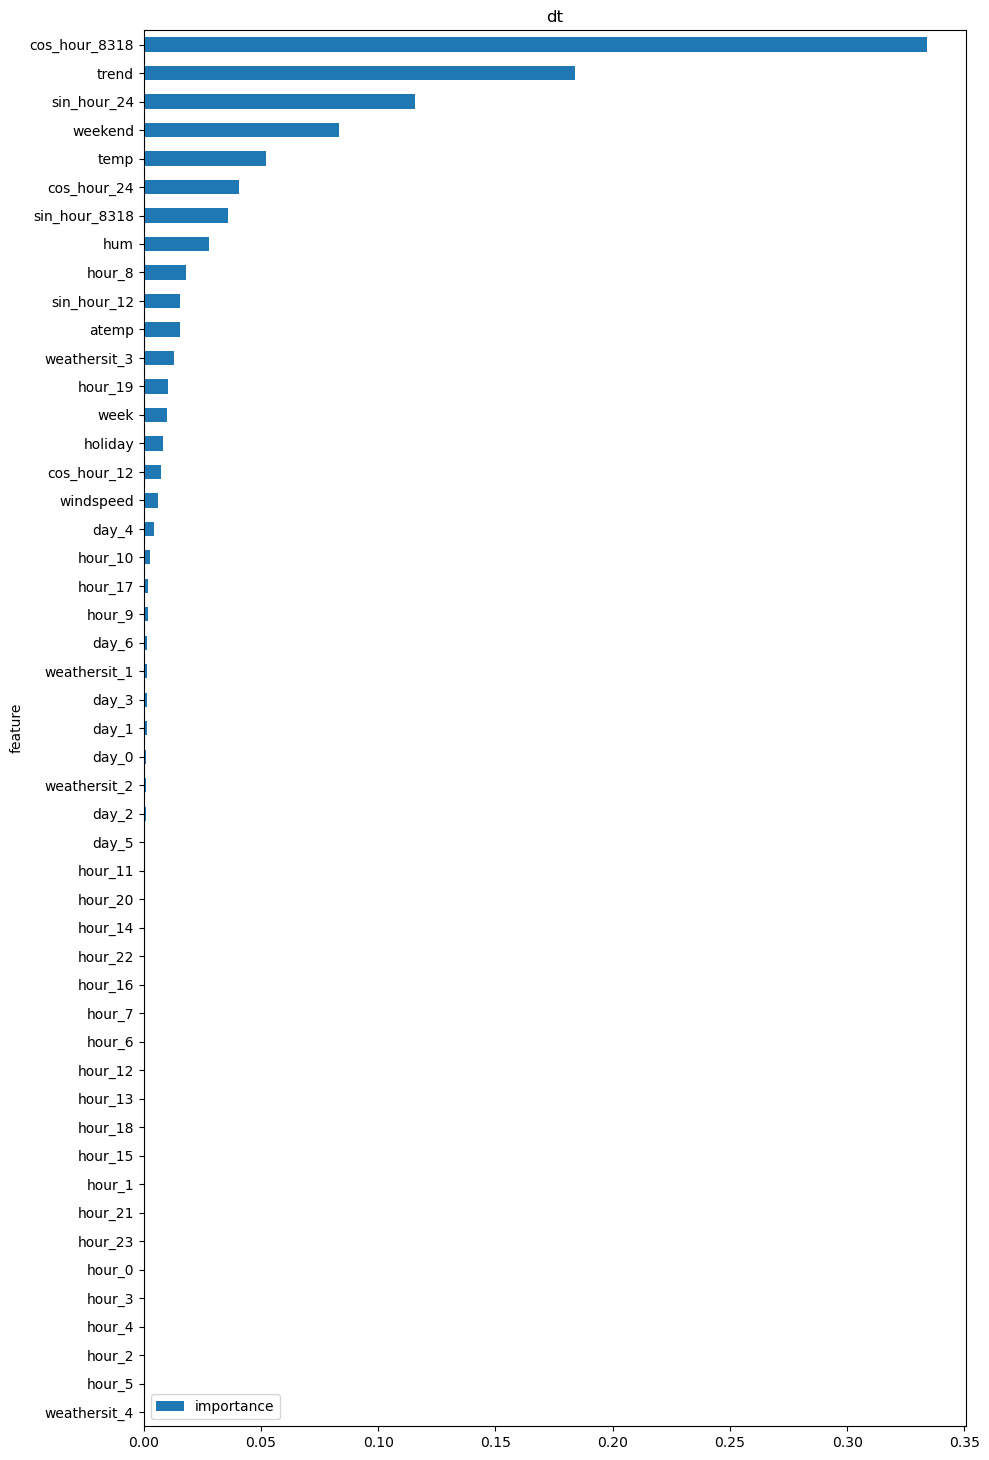

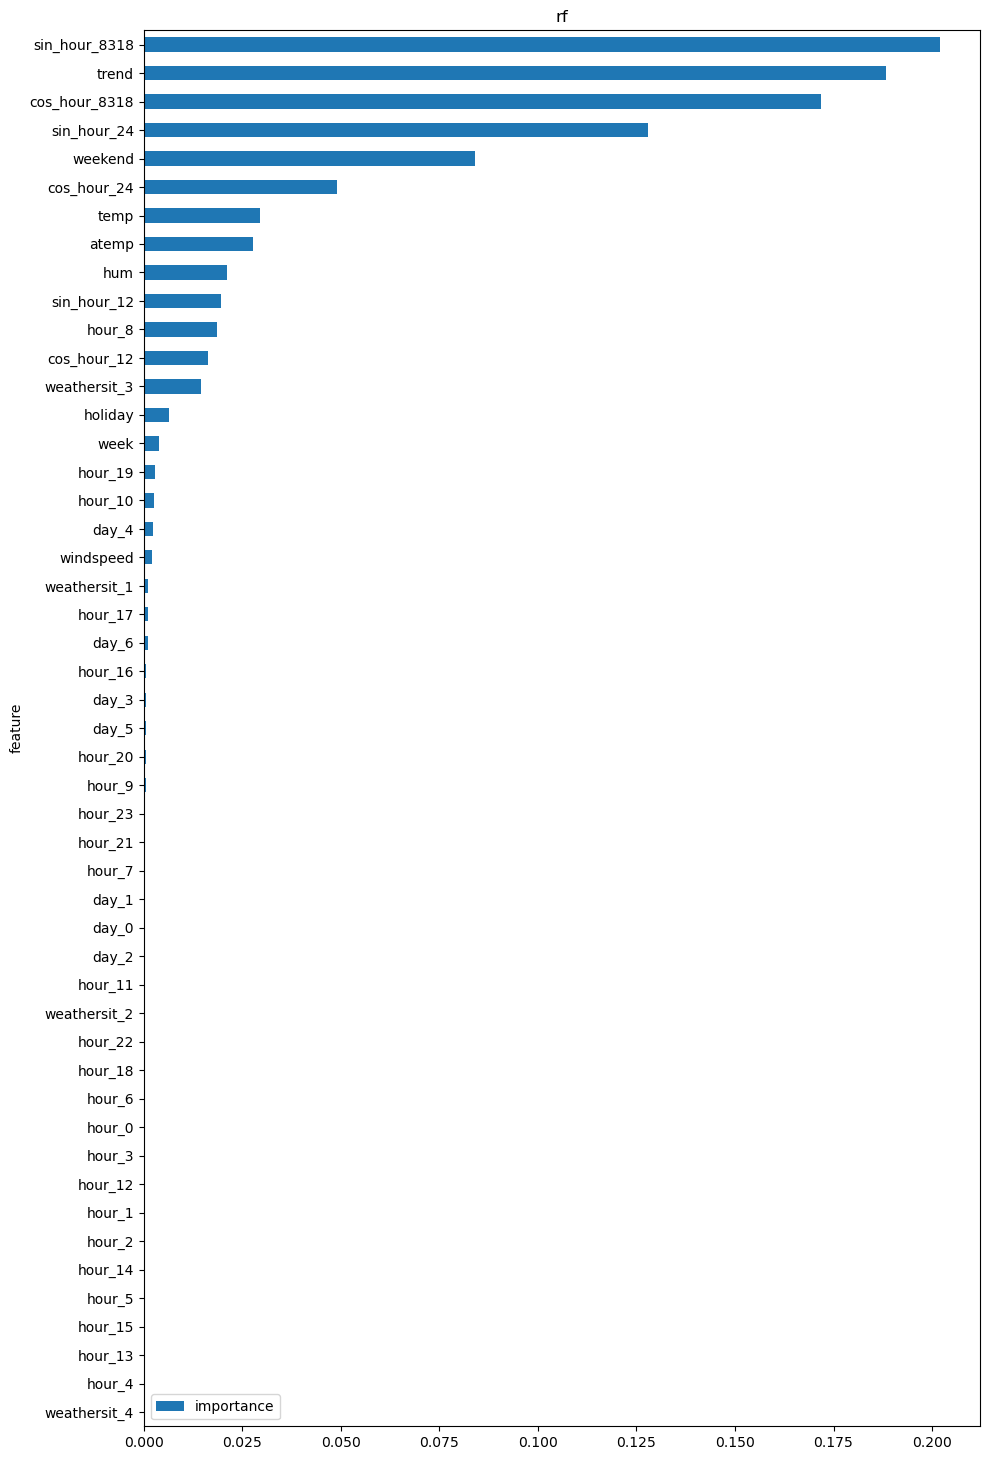

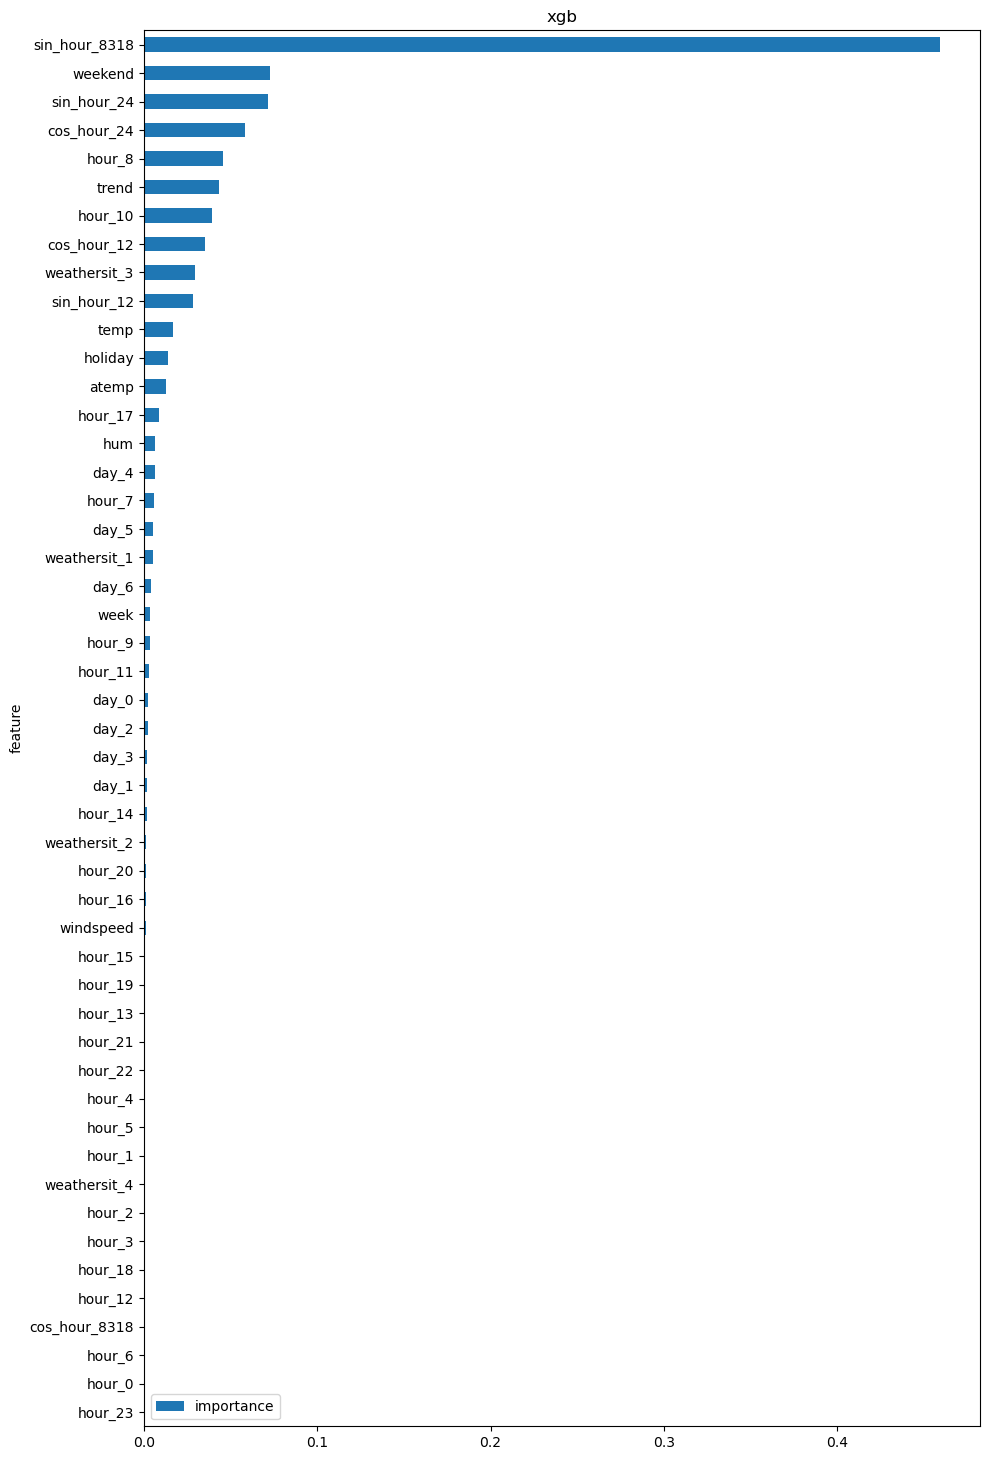

,holiday,temp,atemp,hum,windspeed,week,weekend,trend,sin_hour_24,cos_hour_24,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
date_hour,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,0.24,0.2879,0.81,0.0,1.0,1,1.0,0.000000,1.000000,...,False,False,False,False,False,False,False,False,False,False
2011-01-01 01:00:00,0,0.22,0.2727,0.80,0.0,1.0,1,2.0,0.258819,0.965926,...,False,False,False,False,False,False,False,False,False,False
2011-01-01 02:00:00,0,0.22,0.2727,0.80,0.0,1.0,1,3.0,0.500000,0.866025,...,False,False,False,False,False,False,False,False,False,False
2011-01-01 03:00:00,0,0.24,0.2879,0.75,0.0,1.0,1,4.0,0.707107,0.707107,...,False,False,False,False,False,False,False,False,False,False
2011-01-01 04:00:00,0,0.24,0.2879,0.75,0.0,1.0,1,5.0,0.866025,0.500000,...,False,False,False,False,False,False,False,False,False,False


In [39]:
data.predict()
data.show_feature_importances()

display(data.X_train.head())


## 4.1.2 Gridsearch

In [40]:
models_dict_tune = {
               'lr': [ LinearRegression(), {} ],
               'dt': [ DecisionTreeRegressor(), {'max_depth': [3, 5, 7], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1, 2, 3], 'max_features':['auto', 'sqrt', 'log2']} ],
               'rf': [ RandomForestRegressor(random_state=42, n_jobs=-1), {'n_estimators':[50, 100], 'max_depth': [3, 5, 7], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1, 2, 3], 'max_features':['auto', 'sqrt', 'log2']} ],
               'knn': [ KNeighborsRegressor(), {'n_neighbors':[3, 5], 'weights': ['uniform', 'distance'] }  ],
               'xgb': [ XGBRegressor(random_state=42, n_jobs=-1), {'n_estimators':[100,150 ], 'max_depth': [6, 7, 8], 'learning_rate': [0.01, 0.1, 0.2]} ]             
              }

In [41]:
#gridsearch activate
data.tune_params(n_splits = int(round(len(train)/len(test), 0)), models_dict_tune=models_dict_tune)

lr [{}, 100.94329353607232]
dt [{'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2}, 80.94121268761577]


KeyboardInterrupt: 

## 4.3 Cross-validation voor time series

In [42]:
from sklearn.model_selection import TimeSeriesSplit
kf = TimeSeriesSplit(n_splits=10)
rf = RandomForestRegressor(n_jobs = -1, random_state=42)
param_grid = {"max_depth": [30, 35]} 
model_cv = GridSearchCV(rf, param_grid, cv = kf, n_jobs = -1)
model_cv.fit(data.X_train, data.y_train)
model_cv.best_params_, model_cv.best_score_

model_cv.cv_results_

{'mean_fit_time': array([3.37430654, 5.40568631]),
 'std_fit_time': array([2.34633271, 1.29960451]),
 'mean_score_time': array([1.80381906, 1.94615886]),
 'std_score_time': array([1.27904567, 1.63247681]),
 'param_max_depth': masked_array(data=[30, 35],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 30}, {'max_depth': 35}],
 'split0_test_score': array([0.62284129, 0.62307321]),
 'split1_test_score': array([0.8737921, 0.8736048]),
 'split2_test_score': array([0.86783858, 0.8676902 ]),
 'split3_test_score': array([0.84004831, 0.83958942]),
 'split4_test_score': array([0.61637613, 0.61660305]),
 'split5_test_score': array([0.7753169 , 0.77530963]),
 'split6_test_score': array([0.77647118, 0.77653772]),
 'split7_test_score': array([0.86846148, 0.86829255]),
 'split8_test_score': array([0.8794248 , 0.88196509]),
 'split9_test_score': array([0.93374193, 0.93395303]),
 'mean_test_score': array([0.80543127, 0.80566187]),
 'std_t

### 4.2.1 Leg uit waarom dit anders is voor time series

Doordat je de toekomst wilt voorspellen, moet je elke keer als trainset data voor de testset pakken, dus bij crossvalidation wordt dat stukje trainset steeds groter ten opzichte van de testset.

# 5. Model uitleg

Hieronder wordt aan de hand van de class een gridsearch uitgevoerd voor verschillende voorspellende modellen. De hyperparameters die eruit komen zullen worden gebruikt om de daadwerkelijke voorspellingen mee te doen. Dit zal in onderstaande paragrafen worden uitgevoerd en beschreven.

# **Hou bij welke hyperparameters je gebruikt voor elke kaggle submission voor 6.3**

CSV functie

In [43]:
def submission(model, test, file_name='submission'):
    TEST = test.copy()
    TEST = TEST[data.X_train.columns]
    y_pred = model.predict(TEST)
    y_pred = np.maximum(y_pred, 0) 
    copy_test = TEST.copy()
    copy_test['cnt'] = y_pred
    sub = copy_test[['cnt']].reset_index()

    os.makedirs('predictions', exist_ok=True)

    csv_file = f'predictions/{file_name}.csv'
    sub.to_csv(csv_file, index=False)
    print(f'Submission saved to {csv_file}')
    

## 5.1 (Lineaire regressie) Model 1 waar je time series combineert met reguliere feautures (Lineaire regressie)

### 5.1.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

Wordt gedaan in class hierboven

### 5.1.2 Geef toelichting in de werking van het model en de gekozen parameters

- **Lineaire regressie**
is een methode die wordt gebruikt om de relatie tussen een afhankelijke variabele $y$ en een of meer onafhankelijke variabelen $x$ te modelleren.
  - Voor een meervoudige lineaire regressie met $p$ features is het model als volgt:

$$
\hat{y}_i = b + w_1 x_{i1} + w_2 x_{i2} + \dots + w_p x_{ip}
$$

Of in vectorvorm:

$$
\hat{y}_i = b + \mathbf{w}^\top \mathbf{x}_i
$$

  Waar:

  - $\hat{y}_i$ de voorspelde waarde voor observatie $i$ is,
  - $b$ de intercept (constante term) is,
  - $\mathbf{w} = [w_1, w_2, \dots, w_p]^\top$ de vector van coefficienten is,
  - $\mathbf{x}_i = [x_{i1}, x_{i2}, \dots, x_{ip}]^\top$ de featurevector voor observatie $i$ is.




- **Loss Function**
  - Bij lineaire regressie gebruiken we een loss function om te meten hoe goed ons model presteert. De meest gebruikte loss function is de MSE. MSE berekent het gemiddelde van de kwadraten van de verschillen tussen de predicted waarden en de actual waarden. De formule is:
  
    $$
    \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
    $$
    
    Waar:
    
    - $y_i$ de werkelijke waarde is,
    - $\hat{y}_i$ de voorspelde waarde is,
    - $n$ het aantal observaties is.
    
    Het doel is om de MSE te minimaliseren door de optimale waarden voor de coefficienten (parameters) van het model te vinden. Een lagere MSE betekent dat het model beter presteert.

- **Regularisatie**
  - Regularisatie wordt gebruikt om overfitting te voorkomen door de moeilijkheid van het model terug te dringen. Dit wordt gedaan door een 'penalty' toe te voegen aan de loss function die grote waarden van de coefficienten penaliseert.
  
    - **Lasso (L1 Regularisatie)**
      - Lasso voegt de som van de absolute waarden van de coefficienten toe aan de loss function. De aangepaste loss function wordt:
      
        $$
        \text{Loss} = \text{MSE} + \lambda \sum_{j=1}^{p} |w_j|
        $$
        
        Waar:
        
        - $\lambda$ de regularisatieparameter is die bepaalt hoeveel 'penalty' er wordt toegevoegd,
        - $w_j$ de $j$-de coefficient is,
        - $p$ het aantal features is.
        
        L1 kan coefficienten precies op nul zetten, wat helpt bij feature selectie door onbelangrijke features te verwijderen.
    
    - **Ridge (L2 Regularisatie)**
      - Ridge voegt de som van de kwadraten van de coefficienten toe aan de loss function:
      
        $$
        \text{Loss} = \text{MSE} + \lambda \sum_{j=1}^{p} w_j^2
        $$
        
        L2 helpt dat de coefficienten klein blijven maar nooit nul worden. Dit helpt om multicollineariteit te verminderen en de stabiliteit van het model te verbeteren.
        
- **Voorbeeld:**

Stel je hebt data en je wilt een lineair model fitten. Zonder regularisatie minimaliseer je alleen de MSE en kun je overfitting krijgen. Met regularisatie voeg je een pentalty toe om de coefficienten te beperken.

**Zonder Regularisatie:**

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - (w x_i + b))^2
$$

**Met L1 Regularisatie (Lasso):**

$$
\text{Loss} = \text{MSE} + \lambda \sum_{j=1}^{p} |w_j|
$$

**Met L2 Regularisatie (Ridge):**

$$
\text{Loss} = \text{MSE} + \lambda \sum_{j=1}^{p} w_j^2
$$

Door de juiste waarde voor $\lambda$ te kiezen krijg je een balans tussen een complex en simpel model. Een hogere $\lambda$ betekent meer penalty en dus simpelere modellen, wat kan helpen om overfitting te voorkomen.


- GeeksforGeeks. (2024, 18 september). Ridge Regression vs Lasso Regression. GeeksforGeeks. https://www.geeksforgeeks.org/ridge-regression-vs-lasso-regression/
- LogisticRegression. (z.d.). Scikit-learn. https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html
- Nagpal, A. (2024, 3 oktober). L1 and L2 Regularization Methods, Explained. Built In. https://builtin.com/data-science/l2-regularization
- Megha. (2024, 10 januari). Log Loss vs. Mean Squared Error: Choosing the Right Metric for Classification. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2020/11/binary-cross-entropy-aka-log-loss-the-cost-function-used-in-logistic-regression/

​

**voorbeeld met behulp van ChatGPT**

**Voorbeeld van L1 en L2 Regularisatie met Getallen in Logistic Regression**

Laten we een eenvoudig voorbeeld bekijken van hoe L1 (Lasso) en L2 (Ridge) regularisatie werken in het kader van logistic regression.

**Dataset:**

We hebben een kleine dataset met twee observaties en twee features:

| i | $x_{i1}$ | $x_{i2}$ | $y_i$ |
|---|----------|----------|-------|
| 1 |    1     |    2     |   1   |
| 2 |    2     |    1     |   0   |

**Model:**

We gebruiken een logistic regression model van de vorm:

$$
\hat{y}_i = \sigma(z_i) = \frac{1}{1 + e^{-z_i}}
$$

waarbij:

$$
z_i = w_1 x_{i1} + w_2 x_{i2} + b
$$

We nemen aan dat de gewichten en bias als volgt zijn:

- $w_1 = 0.5$
- $w_2 = -0.5$
- $b = 0$

**Stap 1: Bereken de Voorspellingen**

Voor observatie 1:

$$
z_1 = (0.5)(1) + (-0.5)(2) + 0 = 0.5 - 1 = -0.5
$$

$$
\hat{y}_1 = \sigma(-0.5) = \frac{1}{1 + e^{0.5}} \approx 0.3775
$$

Voor observatie 2:

$$
z_2 = (0.5)(2) + (-0.5)(1) + 0 = 1 - 0.5 = 0.5
$$

$$
\hat{y}_2 = \sigma(0.5) = \frac{1}{1 + e^{-0.5}} \approx 0.6225
$$

**Stap 2: Bereken de Logistieke Verliesfunctie (zonder regularisatie)**

De verliesfunctie voor logistic regression is de binaire cross-entropy:

$$
\text{Loss} = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

Bereken de verlies voor elke observatie:

Voor observatie 1 ($y_1 = 1$):

$$
\text{Loss}_1 = - \left[ (1) \log(0.3775) + (0) \log(1 - 0.3775) \right] = - \log(0.3775) \approx 0.9741
$$

Voor observatie 2 ($y_2 = 0$):

$$
\text{Loss}_2 = - \left[ (0) \log(0.6225) + (1) \log(1 - 0.6225) \right] = - \log(0.3775) \approx 0.9741
$$

Totale verlies zonder regularisatie:

$$
\text{Total Loss} = \frac{1}{2} (0.9741 + 0.9741) = 0.9741
$$

**Stap 3: Bereken de Verliesfunctie met L1 Regularisatie**

De L1 regularisatie term is:

$$
\lambda \sum_{j=1}^{p} |w_j|
$$

Stel $\lambda = 0.1$. Dan is de regularisatieterm:

$$
\text{L1 Regularization} = 0.1 (|0.5| + |-0.5|) = 0.1 (0.5 + 0.5) = 0.1 (1) = 0.1
$$

Totale verlies met L1 regularisatie:

$$
\text{Total Loss}_{\text{L1}} = \text{Loss} + \text{L1 Regularization} = 0.9741 + 0.1 = 1.0741
$$

**Stap 4: Bereken de Verliesfunctie met L2 Regularisatie**

De L2 regularisatie term is:

$$
\lambda \sum_{j=1}^{p} w_j^2
$$

Regularisatieterm:

$$
\text{L2 Regularization} = 0.1 \left( (0.5)^2 + (-0.5)^2 \right) = 0.1 (0.25 + 0.25) = 0.1 (0.5) = 0.05
$$

Totale verlies met L2 regularisatie:

$$
\text{Total Loss}_{\text{L2}} = \text{Loss} + \text{L2 Regularization} = 0.9741 + 0.05 = 1.0241
$$

**Vergelijking van de Verliezen:**

- **Zonder regularisatie:** $\text{Loss} = 0.9741$
- **Met L1 regularisatie:** $\text{Total Loss}_{\text{L1}} = 1.0741$
- **Met L2 regularisatie:** $\text{Total Loss}_{\text{L2}} = 1.0241$

**Interpretatie:**

- **L1 Regularisatie** voegt een grotere penalty toe dan L2 in dit voorbeeld, omdat de som van de absolute waarden van de gewichten groter is dan de som van hun kwadraten.
- **L2 Regularisatie** heeft een kleinere impact op de totale verliesfunctie in dit geval.

**Effect op de Gewichten:**

- Bij het minimaliseren van de totale verliesfunctie zullen de extra regularisatietermen ervoor zorgen dat de optimale gewichten worden aangepast om de penalty te verminderen.
- **L1 Regularisatie** kan sommige gewichten naar precies nul trekken, wat leidt tot een sparsity effect en feature selectie.
- **L2 Regularisatie** vermindert de grootte van de gewichten maar maakt ze zelden precies nul, wat helpt om multicollineariteit te verminderen en het model te stabiliseren.

ChatGPT - L1 en L2 regularisatie. (z.d.). ChatGPT. https://chatgpt.com/share/67489c58-0318-800b-b34d-f399ca37f119

### 5.1.3 Pas het model toe op de testset en upload het resultaat op Kaggle

In [ ]:
model_lr = LinearRegression()
model_lr.fit(data.X_train, data.y_train.values.ravel())

submission(model_lr, test, 'linear_regression')

Submission saved to predictions/linear_regression.csv


## 5.2 (Decision Tree) Model 2 waar je time series combineert met reguliere feautures (Decision Tree)

### 5.2.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

Wordt gedaan in class hierboven

### 5.2.2 Geef toelichting in de werking van het model en de gekozen parameters

**De werking van een decision tree**

Een decision tree begint met de gehele dataset als input voor de voorspelling. Bij dit model wordt een dataset herhaaldelijk gesplitst in kleinere subsets op basis van 'beslissingsregels' tot het model voldoende specifieke subsets heeft om een duidelijke voorspelling te maken.

De regressie versie van een decision tree wordt per boom gesplitst op een andere manier dan dat het gebeurt bij een classifier. In plaats van dat er wordt gekeken naar de information gain & gini impurity, wordt er hierbij gebruikt gemaakt van de MSE (Mean Squared Error). Deze metric berekent hoe ver de werkelijke waarden afwijken van de voorspelde waarde (het gemiddelde in een 'leaf' van de tree). De bomen proberen elke splitsing zo te maken dat de voorspeelde waarde zo nauwkeurig mogelijk is. Het model kiest uiteindelijk elke keer de splitsing die de grootste reductie in de variatie (fout) oplevert. 

Na het bepalen van de beste splitsing, wordt dit proces herhaald op de resulterende subsets. Elke nieuwe subset wordt opnieuw opgesplitst op basis van een nieuwe feature en splitsingsregel. Dit proces gaat door totdat een van de volgende stopcriteria wordt bereikt:

Minimale variatie: De variatie binnen een groep is niet verder te verminderen (de MSE bereikt een minimale waarde).

Pruning: Het proces wordt handmatig beperkt door hyperparameters zoals:

- Max depth: Het maximale aantal lagen in de boom.
- Min samples split: Het minimale aantal gegevenspunten dat nodig is om een splitsing te maken.
- Min samples leaf: Het minimale aantal gegevenspunten dat een leaf node moet bevatten.

Elke tree van het model voorspelt een continu (numeriek) resultaat, en het uiteindelijke resultaat van de decision tree wordt berekend door het gemiddelde van de voorspellingen van alle bomen te nemen. 

Voordelen van de decision tree regressor:

- Het model is interpreteerbaar omdat de beslissingsregels eenvoudig te volgen zijn.
- Het kan omgaan met niet-lineaire relaties tussen de inputvariabelen en de targetvariabele

Nadelen

- Een volledig getrainde tree kan overfitten, waarbij het model te specifiek wordt voor de trainingsdata en daardoor slecht generaliseert naar nieuwe data.

Dit is de MSE functie die wordt gebruikt bij het maken van de splitsingen:

$$
MSE = \frac{1}{n} \sum_{i=1}^n (Y_i - \hat{Y})^2
$$

Werkelijke waarde

$$ Y_i $$

Voorspelde waarde (gemiddelde van de groep)
$$ \hat{Y} $$

Aantal gegevenspunten in de groep (samples)
$$ {n} $$

Baladram, S. (2024, 19 november). Regression Tree | towards Data science. Medium. https://towardsdatascience.com/decision-tree-regressor-explained-a-visual-guide-with-code-examples-fbd2836c3bef

### 5.2.3 Pas het model toe op de testset en upload het resultaat op Kaggle

In [ ]:
model_dt = DecisionTreeRegressor(max_depth=7, max_features='auto', min_samples_leaf=3, min_samples_split=6, random_state=42)
model_dt.fit(data.X_train, data.y_train.values.ravel())

submission(model_dt, test, 'DecisionTreeRegressor')

Submission saved to predictions/DecisionTreeRegressor.csv


## 5.3 (Random Forest) Model 3 waar je time series combineert met reguliere feautures

### 5.3.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

Wordt gedaan in class hierboven

### 5.3.2 Geef toelichting in de werking van het model en de gekozen parameters

**Random Forest**

Random forest is een machine learning model dat is gebaseerd op bagging. Bij bagging worden meerdere versies van hetzelfde model getraind op verschillende subsets van de dataset, die wordt verkregen door een techniek genaamd Bootstrap Aggregating. Dit houdt in dat er nieuwe datasets worden gecreëerd door samples uit de oorspronkelijke dataset te trekken met "terugleggen" (dezelfde datapunten kunnen meerdere keren worden geselecteerd), genaamd bootstrap samples. Elke tree leert daardoor van een iets andere dataset, waardoor de modellen gediversifieerd worden. 

Daarnaast worden er ook willekeurige features (kolommen) gekozen. Bij elke splitsing van een tree, wordt slechts een willekeurige subset van de beschikbare features overwogen, in plaats van alle features. Dit voorkomt dat dominante features (met hoge voorspellende kracht) alle splitsingen in alle bomen domineren en zorgt ervoor dat de bomen minder gecorreleerd zijn. Door dit te doen wordt het model ook sterker en minder vatbaar voor overfitting. Dit allemaal wordt gedaan aan de hand van de max_features parameter. 

Elke tree van het model voorspelt een continu (numeriek) resultaat, en het uiteindelijke resultaat van de random forest wordt berekend door het gemiddelde van de voorspellingen van alle bomen te nemen. Door het gebruik van het gemiddelde van alle bomen vermindert het model het risico op foutieve voorspellingen veroorzaakt door ruis in individuele bomen.

Voordelen:  
-Doordat er meerdere modellen naast elkaar worden getrained, kan het overfitting voorkomen.   
-Doordat de trees onafhankelijk van elkaar worden getrained, kunnen ze parallel worden verwerkt. Hierdoor is de trainingstijd dus relatief snel in vergelijking met Gradient Descent Boosting.   

Nadelen:  
-Ze zijn lastiger te interpreteren dan een losse decision tree.   
-Er zijn veel hyper parameters om te tunen.   

**Wiskunde**

Aangezien een random forest het gemiddelde van alle voorspelling van de individuele bomen pakt, moet deze worden berekend. Dit wordt gedaan aan de hand van de onderstaande formule, waarbij K het aantal bomen in de forest is:

$$
\hat{y}(x) = \frac{1}{K} \sum_{k=1}^{K} f_k(x)
$$

De formule is opgebouwd uit:
$$
\hat{y}(x)
$$
Dit is de voorspelling van het ensemble model voor een invoer van x.

$$
K
$$

Dit is het totaal aantal modellen in de ensemble (totaal aantal decision trees in dit geval)

$$
f_k(x)
$$

Dit is de voorspelling van het 'k-de' model in de ensemble voor een invoer van x

<br>


Net zoals bij decision trees wordt er gebruik gemaakt van de MSE metric om te bepalen wat de beste splitsingen zijn:

$$
MSE = \frac{1}{n} \sum_{i=1}^n (Y_i - \hat{Y})^2
$$

De formule is opgebouwd uit:
$$
{n}
$$

Dit is het aantal waarnemingen in de dataset.

$$
Y_i
$$

Dit is de werkelijke waarde van de waarneming.

$$
\hat{Y}
$$

Dit is de voorspelde waarde.


AnalytixLabs. (2023, 26 december). Random Forest Regression — How it Helps in Predictive Analytics? Medium. https://medium.com/@byanalytixlabs/random-forest-regression-how-it-helps-in-predictive-analytics-01c31897c1d4

### 5.3.3 Pas het model toe op de testset en upload het resultaat op Kaggle

In [ ]:
model_rf = RandomForestRegressor(max_depth=7, max_features='auto', min_samples_leaf=2, min_samples_split=2, n_estimators=100)
model_rf.fit(data.X_train, data.y_train.values.ravel())

submission(model_rf, test, 'RandomForestRegressor')

Submission saved to predictions/RandomForestRegressor.csv


## 5.4 (KNN) Model 4 waar je time series combineert met reguliere feautures

### 5.4.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

Wordt gedaan in class hierboven

### 5.4.2 Geef toelichting in de werking van het model en de gekozen parameters

K-Nearest Neighbours (KNN) is een simpel algoritme die te gebruiken is voor classificatie en regressie problemen. Het werkt door de "K" nearest datapoints(Neighbors) voor een nieuwe punt te indentificeren op basis van een 'Afstand' hierover meer later. Een voorspelling word gedaan met gebruik van een meerderheidslabel (classification) of het gemiddelde (regression) van deze Neighbours.

Bij het gebruik van een KNN model is de afstand heel belangrijk en ook het aantal Neighbors omdat dit invloed kan hebben op de 'Fitting'

- Euclidean
  - Een rechte lijn tussen twee punten in een Euclidean space (multidimensionale ruimte) dit wordt gedaan met de formule:
$$
d(\mathbf{x}_i, \mathbf{x}_j) = \sqrt{ \sum_{k=1}^{n} (x_{ik} - x_{jk})^2 }
$$
  - Het werkt vooral goed in laag dimensionale ruimten omdat het verschil tussen punten minder betekenisvol zijn in hoge dimensies. Minder kolommen is dus beter voor Euclidean distance
- Manhattan
  - Manhattan distance is bekend als stadsblokafstand en daarom ook genaamd naar Manhattan omdat Manhattan van boven erg veel lijkt op de manier waarop de distance word berekent. In het kort ga je een afstand berekenen door een echte route te lopen in plaats van Euclidean die dwars door gebouwen heen gaat:
  - de formule:

$$d(P, Q) = |q_1 - p_1| + |q_2 - p_2|$$

Voor meer dan 2 dimensies:

$$d(P, Q) = \sum_{i=1}^{n} |q_i - p_i|$$

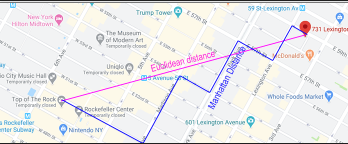

[source](https://www.translatorscafe.com/unit-converter/bg/calculator/two-points-distance/?D=2&x1=3&y1=3.5&x2=-5.1&y2=-5.2)
  - Deze afstand is de som van de absolute verschillen tussen punten in alle dimensies en wordt berekent met : 
  - Manhattan distance is minder gevoelig tegen multidimensionale ruimtes omdat het geen kwadraten berekent maar de absolute verschillen optelt.


- [Weights](https://visualstudiomagazine.com/articles/2019/04/01/weighted-k-nn-classification.aspx) [additional source](https://towardsai.net/p/l/understanding-k-nearest-neighbors-a-simple-approach-to-classification-and-regression)
  - Uniform(default)
    - Bij het gebruiken van Uniform als gewicht zorg je dat elk van de 'K' Neighbors evenveel bijdraagt aan het resultaat. Oftewel, een punt die dichtbij ligt heeft even veel invloed als een punt die ver ligt.
  - Distance
    - Bij het gebruiken van Distance als gewicht heeft de afstand van de 'K' Neighbors invloed op hoeveel het bijdraagt aan het resultaat. De afstand word berekent met  1/d  en d = afstand tot Neighbour. 
- Voorbeeld :

| Punt   | Doelwaarde   | Afstand | Gewicht (Uniform) | Gewicht (Distance) |
|--------|----------|---------|-------------------|-------------------|
| Punt 1 | 5 | 5       | 1                 | $\frac{1}{5} = 0{,}2$              |
| Punt 2 | 7 | 7       | 1                 | $\frac{1}{7} \approx 0{,}14$           |
| Punt 3 | 1 | 1       | 1                 | $\frac{1}{1} = 1{,}0$              |

**Uniforme gewichten:**

Voorspelde waarde:

$$
\hat{y} = \frac{5 + 7 + 1}{3} = \frac{13}{3} \approx 4{,}33
$$

**Afstandsgewogen:**

Berekening van gewogen som:

$$
\text{Gewogen som} = (5 \times 0{,}2) + (7 \times 0{,}14) + (1 \times 1{,}0) = 1{,}0 + 0{,}98 + 1{,}0 = 2{,}98
$$

Som van de gewichten:

$$
\text{Som gewichten} = 0{,}2 + 0{,}14 + 1{,}0 = 1{,}34
$$

Voorspelde waarde:

$$
\hat{y} = \frac{2{,}98}{1{,}34} \approx 2{,}22
$$


- ['K' Waarde](https://www.kdnuggets.com/2022/07/knearest-neighbors-scikitlearn.html)
  - De waarde van 'k' is van cruciaal belang voor de prestaties van het model. Een kleine 'k' kan leiden tot overfitting omdat het model hierdoor gevoelig wordt voor ruis, terwijl een grote 'k' de voorspellingen kan overdrijven en subtiele patronen kan negeren. Meestal worden oneven waarden van 'k' gekozen om verbanden in de classificatie te vermijden, bij regressie kan je elke K waarde nemen. 

het schalen van functies zoals standaardisatie is vaak nodig om ervoor te zorgen dat de distance metrics nog meaningful zijn.


- K-nearest Neighbors in Scikit-learn. (z.d.). https://www.kdnuggets.com/2022/07/knearest-neighbors-scikitlearn.html
- Weighted K-NN classification using Python -- Visual Studio Magazine. (2019, 1 april). Visual Studio Magazine. https://visualstudiomagazine.com/articles/2019/04/01/weighted-k-nn-classification.aspx
- Ifttt-User. (2023, 2 juni). Understanding K-Nearest Neighbors: A Simple Approach to Classification and Regression. Towards AI. https://towardsai.net/p/l/understanding-k-nearest-neighbors-a-simple-approach-to-classification-and-regression
  
​


### 5.4.3 Pas het model toe op de testset en upload het resultaat op Kaggle

In [ ]:
model_knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
model_knn.fit(data.X_train, data.y_train.values.ravel())

submission(model_knn, test, 'KNeighborsRegressor')

Submission saved to predictions/KNeighborsRegressor.csv


## 5.5 (XGBoost) Model 5 waar je time series combineert met reguliere feautures

### 5.5.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

Wordt gedaan in class hierboven

### 5.5.2 Geef toelichting in de werking van het model en de gekozen parameters


**Gradient Boosting**

XGBoost doet eigenlijk vrijwel hetzelfde als gradient boosting. Hierbij worden modellen (in dit geval beslisbomen) iteratief worden toegevoegd om fouten te corrigeren die de vorige bomen hebben gemaakt.

•	Het proces begint met een eenvoudige voorspelling, zoals het gemiddelde van de target y. Deze voorspelling heet $$F_0(x)$$

•	In elke volgende stap t, wordt een nieuwe beslisboom getraind om de residuen te voorspellen, oftewel de fouten van het vorige model. $$(r_i = y_i - F_{t-1}(x_i))$$ 

•	De voorspelling wordt aangepast met een fractie van de nieuwe boom $$\eta \times \text{nieuw model}$$ hier is η de learning rate.

$$F_t(x) = F_{t-1}(x) + \eta \cdot h_t(x)$$

De beslisboom die in stap t wordt toegevoegd is dan $$h_t(x)$$

**beslisbomen**

Een beslisboom in XGBoost splitst de dataset herhaaldelijk op basis van kenmerken die de grootste reductie in de fout opleveren. Elke knoop in de boom verdeelt de data in steeds wat kleinere groepen, zodat de eindwaarden (ook wel "leaf values" genoemd) de fouten minimaliseren.

•	Bij regressie wordt de voorspelling aangepast met de som van de waardes in de bladeren waar de datapunten terechtkomen.

<br>


**Regularisatie**

XGBoost gebruikt L1- en L2-regularisatie om de waarden van de bladeren en de splitsingen in te perken.

•	L1-regularisatie: Zorgt ervoor dat sommige bladeren een waarde van exact 0 krijgen, wat betekent dat de splitsingen met deze waarde geen invloed hebben op de uiteindelijke voorspelling.

•	L2-regularisatie: Voorkomt dat bladwaarden extreem groot worden, wat helpt om de stabiliteit van de voorspellingen te waarborgen.

<br>

**Parallel trainen**

Binnen één beslisboom wordt voor elk kenmerk berekend hoe effectief een splitsing is bij het verminderen van fouten. Ook is het mogelijk dat de XGBoost dit trainen verdeelt over meerder CPU-Cores, waardoor dit nog sneller wordt gedaan. 

<br>

**Tree pruning**

Bij het maken van een boom kijkt XGBoost of het toevoegen van een bepaalde splitsing de prestaties van het model voldoende verbeterd. De splitsingen die dit niet doen worden achteraf d.m.v. post-pruning verwijderd.

<br>

**Learning rate (eta)**

De learning rate binnen XGBoost bepaalt hoeveel elke boom toevoegdt aan de uiteindleijk voorspelling. 

<br>

**Schaalbaarheid**

Bij datasets die niet in het geheugen passen, verwerkt XGBoost de data in kleine batches (out-of-core computing). Dit maakt het mogelijk om efficiënt met grote tijdreeksen of datasets met miljoenen rijen te werken.

<br>

ChatGPT - XGBoost regressie uitleg. (n.d.). ChatGPT. https://chatgpt.com/share/6744dd90-bf5c-8002-8884-6606bfdb29c5

XGBoost Documentation — xgboost 2.1.1 documentation. (n.d.). https://xgboost.readthedocs.io/en/stable/

### 5.5.3 Pas het model toe op de testset en upload het resultaat op Kaggle

In [ ]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=100)
model_xgb.fit(data.X_train, data.y_train.values.ravel())

submission(model_xgb, test, 'XGBRegressor')

Submission saved to predictions/XGBRegressor.csv


## 5.6 (SARIMA) Model 1 van specifieke tijdseriemodellen (SARIMAX)

In [45]:
train.reset_index(inplace=True)
train_ar = train[['date_hour', 'cnt']]

### 5.6.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

In [ ]:
# Set initial values and some bounds
ps = [7]
d = 0
qs = [0,1,4]
Ps = [7]
D = 0
Qs = [4]
s = 24

# Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters, corresponding AIC, and RMSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    best_rmse = float('inf')
    
    for param in tqdm(parameters_list):
        try:
            model = sm.tsa.statespace.SARIMAX(train['cnt'], order=(param[0], d, param[1]),
                                              seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        predictions = model.predict(start=0, end=len(train['cnt'])-1)
        rmse = mean_squared_error(train['cnt'], predictions, squared=False)
        
        # Save best model, AIC, RMSE, and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        if rmse < best_rmse:
            best_rmse = rmse
        results.append([param, model.aic, rmse])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic', 'rmse']
    # Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

# Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(train['cnt'], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)



print(best_model.summary())
print(f"Best RMSE: {result_table.rmse[0]}")

  0%|          | 0/2 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                                  cnt   No. Observations:                16637
Model:             SARIMAX(7, 1, 4)x(3, 1, [1], 24)   Log Likelihood              -91382.846
Date:                              Sun, 01 Dec 2024   AIC                         182797.691
Time:                                      17:52:59   BIC                         182921.177
Sample:                                           0   HQIC                        182838.458
                                            - 16637                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.1091      0.092     22.923      0.000       1.929       2.289
ar.L2         -2.77

In [64]:
models_dict = {'sx': SARIMAX(endog=train_ar['cnt'].values.ravel(), order=(7, 1, 4), seasonal_order=(3, 1, 1, 24)),
               }

In [65]:
class TimeSeriesModels:
    def __init__(self, data, target, shuffle=True, test_size=0.2, random_state=42):
        self.data = data            
        self.X = self.data.drop(target, axis=1)
        self.y = self.data[[target]]        
        self.X_train_s, self.X_test_s, self.y_train_s, self.y_test_s = train_test_split(self.X, self.y,
                                                                                test_size=test_size, shuffle=shuffle, 
                                                                                random_state=random_state)

    def predict(self, models=models_dict):
        self.models_dict = models
        for name, model in self.models_dict.items():
            if isinstance(model, SARIMAX):
                fitted_model = model.fit(disp=False)
                
                self.y_train_pred = fitted_model.predict(start=self.y_train_s.index[0], end=self.y_train_s.index[-1])
                self.y_test_pred = fitted_model.predict(start=self.y_test_s.index[0], end=self.y_test_s.index[-1])
                
                # Plot diagnostics
                fig = fitted_model.plot_diagnostics(figsize=(10, 7))
                fig.autofmt_xdate()
                plt.show()
                
                # Plot forecast
                plt.figure(figsize=(14, 7))
                plt.plot(self.y_train_s.index, self.y_train_s, label='Train')
                plt.plot(self.y_test_s.index, self.y_test_s, label='Test')
                plt.plot(self.y_train_s.index, self.y_train_pred, label='Train Prediction')
                plt.plot(self.y_test_s.index, self.y_test_pred, label='Test Prediction')
                plt.legend()
                plt.title(f'{name} Forecast')
                plt.show()
            
            train_rmse = np.sqrt(mean_squared_error(self.y_train_s, self.y_train_pred))
            test_rmse = np.sqrt(mean_squared_error(self.y_test_s, self.y_test_pred))
            print(f'{name} train RMSE:', train_rmse)
            print(f'{name} test RMSE:', test_rmse)
    

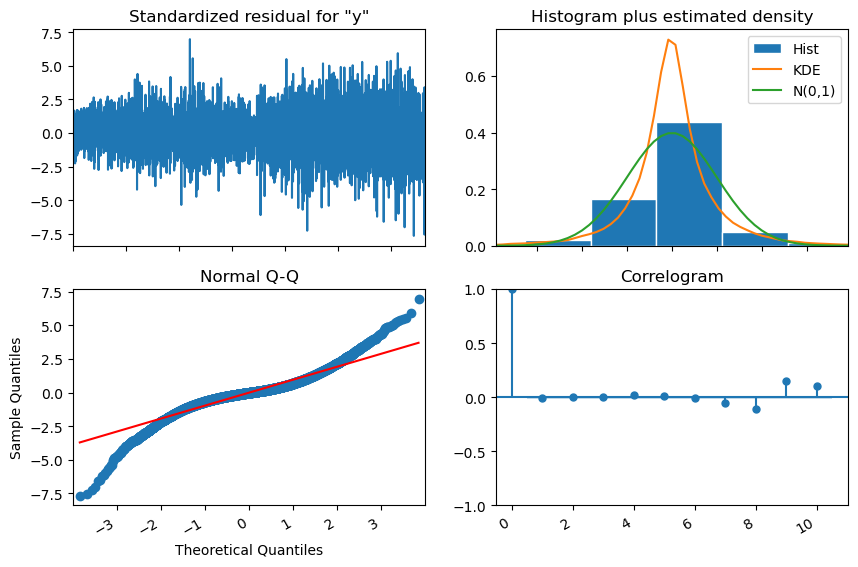

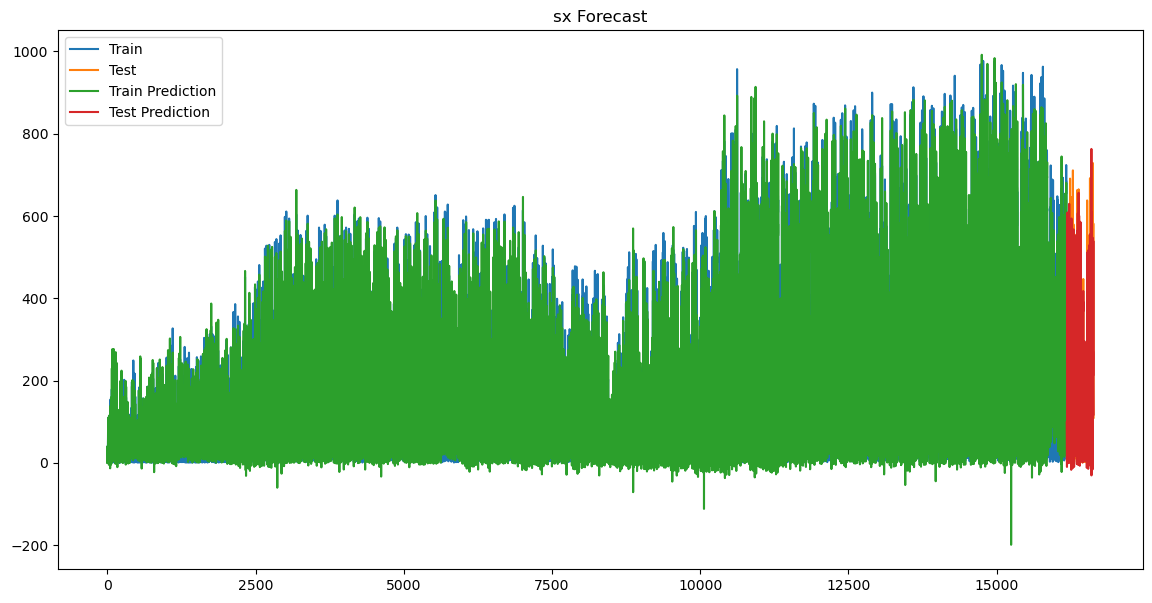

sx train RMSE: 58.824053317807895
sx test RMSE: 68.15943725735423


In [66]:
data_s = TimeSeriesModels(data=train_ar, target='cnt', shuffle=False, test_size=19*24)
data_s.predict()

### 5.6.2 Geef toelichting in de werking van het model en de gekozen parameters

SARIMA wordt gekarakteriseerd door de notatie:

SARIMA(p, d, q)(P, D, Q, s)

Niet-seizoensgebonden componenten (ARIMA-deel):

p (AR): Autoregressieve orde. Het aantal lagged observaties dat in het model wordt opgenomen. We kiezen hierbij voor 7 omdat die uit de ACF/PACF plots eerder kwam.

d (I): Differentiëringsorde. Het aantal keer dat de data wordt gedifferentieerd om stationariteit te bereiken. Hier kiezen we voor 0 omdat het al stationary is, dit bleek uit de ACF/PACF plots eerder.

q (MA): Moving average-orde. Het aantal lagged voorspellingsfouten in het model. Hiervoor zoeken we naar de beste waarde

Seizoensgebonden componenten:

P (SAR): Seizoensgebonden autoregressieve orde. Het aantal seizoensgebonden lag-observaties. We kiezen hierbij voor 7 omdat die uit de ACF/PACF plots eerder kwam.

D (SI): Seizoensgebonden differentiëringsorde. Het aantal seizoensgebonden verschillen om de data stationair te maken. Hier kiezen we voor 0 omdat het al stationary is, dit bleek uit de ACF/PACF plots eerder.

Q (SMA): Seizoensgebonden moving average-orde. Het aantal seizoensgebonden lagged voorspellingsfouten. Hiervoor zoeken we naar de beste waarde

s: Seizoensperiode. Het aantal tijdstappen per seizoenscyclus. Wij gebruiken 24 voor onze dagelijkse seizoenscyslus

Hoe werkt het verder?

Het SARIMA-model combineert korte-termijnpatronen (zoals kleine fluctuaties van maand tot maand) en lange-termijnpatronen (zoals herhalende jaarlijkse pieken). Dit zijn de stappen:

**Autoregressie (AR)**: Het model kijkt hoe het huidige uur beïnvloed wordt door de vorige uren.

Voorbeeld: Als je verhuur het uur of een dag ervoor op hetzelfde uur hoog is, kan dat een indicator zijn dat de dag erna ook hoog zal zijn.

**Differentiatie (I)**: Dit verwijdert trends uit de data om deze stationair te maken. Het model neemt verschillen tussen op volgorde lopende datapunten of seizoenscycli om langetermijntrends en willekeurige stijgingen/dalingen te verminderen/helemaal weg te halen.

Voorbeeld: Als de verhuur over de jaren heen geleidelijk stijgt (bijvoorbeeld door meer gebruikers, wat in onze data het geval lijkt te zijn), zal differentiatie deze stijging neutraliseren, zodat het model zich kan richten op de kortere-termijnfluctuaties.

**Moving Average (MA)**: Het model corrigeert voorspellingen door te kijken naar eerdere fouten.

Voorbeeld: Als het model in week 1 de verhuur te hoog inschatte, kan het deze fout meenemen om week 2 nauwkeuriger te voorspellen.

**Seizoenscomponenten**: Het model herkent herhalende patronen in de data.

Voorbeeld: De piek in de verhuur vindt vooral in de zomer plaats, en SARIMA leert dit patroon te voorspellen.

**Periodiciteit (s)**: Dit geeft aan hoe vaak het patroon zich herhaalt.

Voorbeeld: Voor uurlijkse data met een dagelijks patroon is s dus 24.

**de wiskunde formule gaat als volgt**
$$(1−ϕ1B)(1−Φ1Bs)(1−B)(1−Bs)yt=(1+θ1B)(1+Θ1Bs)εt$$
​
- *yt* is hier de tijdserie op tijd t

- B is hier het aantal lags

- ϕ1 is hier de coefficient van de niet seizoens gebonde autoregressie

- Φ1 is de coefficient van de seizoens gebonde autoregressie

- θ1 is hier de moving average coefficient van de niet seizoens gebonde autoregressie

- Θ1 is hier de moving average coefficient van de seizoens gebonde autoregressie

- s is the seizoens periode

- εt is de ruis error term op tijd t.
​

GeeksforGeeks. (2024a, May 24). SARIMA (Seasonal Autoregressive Integrated Moving Average). GeeksforGeeks. https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/

ChatGPT - SARIMA model Overview. (n.d.). ChatGPT. https://chatgpt.com/share/6749d42f-47e4-8002-8698-ce222bd0fb76
 

**Hoe zit het met ons model?**

In de grafieken zien we dan de standardized residual, geen duidelijke patronen laat zien.

De histrogram van de KDE estimate kan beter, dit moet in het beste geval lijken op een normaal verdeling. Dit is niet helemaal het geval, maar het wijkt er niet te erg van af.

Vervolgs zien we de Normal Q-Q grafiek, hier zien we dat het grootste deel van depunten op de lijn ligt. Het is wel duidelijk dat het model niet perfect werkt door deze lijn.

Als laatste zien we de correlogram, hier is het doel om alle lags binnen de confidence band te krijgen. We zien hier dat 8, 9 en 10 hier toch wel erg buiten liggen. Hier is dus ook nog ruimte voor verbetering als dit mogelijk is.

In onze forecast grafiek zien we redelijk goede resultaten, wat vrij goed overeenkomt met de orginele data. Maar hier valt iets anders op, er worden namelijk negatieve getallen voorspeld. Dit kan in de werklijkheid niet, daarom lossen we dit op door alle negatieve waardes te vervangen met 0.
Dit zou het model iets beter laten werken en met een msre van 68 is dit al een van onze best werkende modellen.

 



### 5.6.3 Pas het model toe op de testset en upload het resultaat op Kaggle

In [ ]:
import os
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

def submission(model, test, file_name='submission'):
    TEST = test.copy()
    TEST = TEST[data.X_train.columns] 
    y_pred = model.get_forecast(steps=len(TEST)).predicted_mean
    y_pred = np.maximum(y_pred, 0)  
    copy_test = TEST.copy()
    copy_test['cnt'] = y_pred
    sub = copy_test[['cnt']].reset_index()

    os.makedirs('predictions', exist_ok=True)

    csv_file = f'predictions/{file_name}.csv'
    sub.to_csv(csv_file, index=False)
    print(f'Submission saved to {csv_file}')
    
model_sar = SARIMAX(endog=train_ar['cnt'].values.ravel(), order=(7, 1, 4), seasonal_order=(3, 1, 1, 24)).fit(disp=False)
submission(model_sar, test, 'SARIMAX')

Submission saved to predictions/SARIMAX.csv


## 5.7 (Prophet) Model 2 van specifieke tijdseriemodellen

In [ ]:
test.reset_index(inplace=True)

20:46:39 - cmdstanpy - INFO - Chain [1] start processing
20:46:41 - cmdstanpy - INFO - Chain [1] done processing


                     ds        yhat  yhat_lower  yhat_upper
0   2012-12-01 00:00:00  117.622083  -17.337441  263.045219
1   2012-12-01 01:00:00  103.624622  -32.015101  239.440579
2   2012-12-01 02:00:00   53.537334  -74.635535  195.233656
3   2012-12-01 03:00:00   11.402417 -113.011787  154.470529
4   2012-12-01 04:00:00   27.790096  -99.473987  170.843157
..                  ...         ...         ...         ...
451 2012-12-19 19:00:00  421.256917  280.387738  552.749164
452 2012-12-19 20:00:00  326.967673  191.711185  463.183045
453 2012-12-19 21:00:00  224.006341   78.363618  353.992819
454 2012-12-19 22:00:00  168.719817   35.885877  310.194244
455 2012-12-19 23:00:00  144.302459    6.251911  288.131790

[456 rows x 4 columns]


  0%|          | 0/2 [00:00<?, ?it/s]

20:46:42 - cmdstanpy - INFO - Chain [1] start processing
20:46:43 - cmdstanpy - INFO - Chain [1] done processing
20:46:44 - cmdstanpy - INFO - Chain [1] start processing
20:46:46 - cmdstanpy - INFO - Chain [1] done processing


             horizon           mse        rmse         mae      mape  \
0    1 days 19:00:00  17573.921588  132.566668  103.383022  3.096106   
1    1 days 20:00:00  17178.495255  131.066759  101.015456  3.005652   
2    1 days 21:00:00  16924.856842  130.095568   99.729764  2.794454   
3    1 days 22:00:00  16735.189567  129.364561   98.853440  2.687845   
4    1 days 23:00:00  16581.944004  128.770897   97.645440  2.190641   
..               ...           ...         ...         ...       ...   
385 17 days 20:00:00  24164.185200  155.448336  121.599098  2.120251   
386 17 days 21:00:00  24036.349231  155.036606  120.892791  2.043057   
387 17 days 22:00:00  23842.314529  154.409567  119.603138  1.906993   
388 17 days 23:00:00  23630.926104  153.723538  117.747568  1.775193   
389 18 days 00:00:00  23607.307896  153.646698  117.686868  1.622713   

        mdape     smape  coverage  
0    0.422928  0.634450  0.709302  
1    0.406211  0.608390  0.732558  
2    0.397070  0.575135  0.

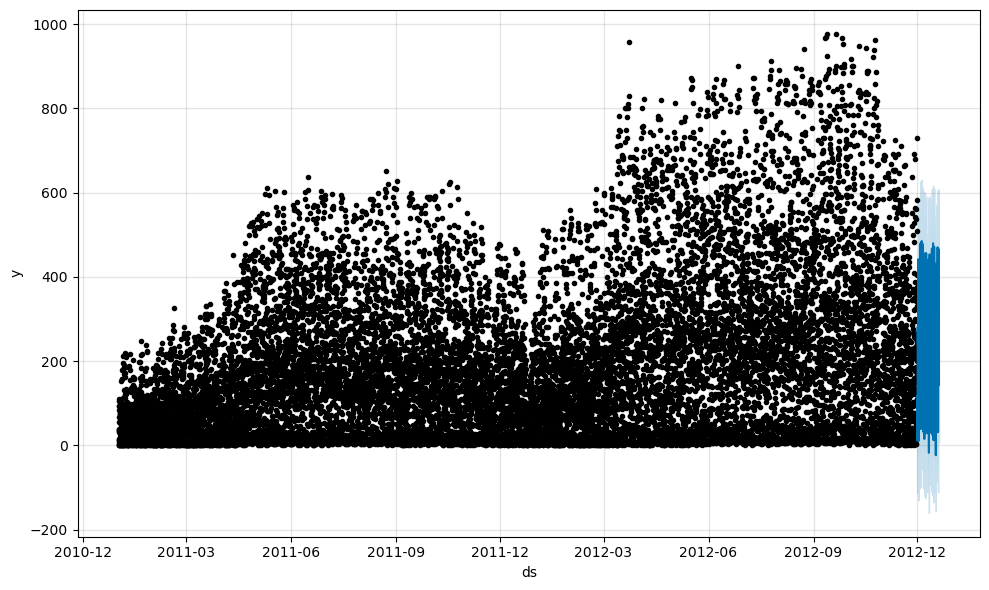

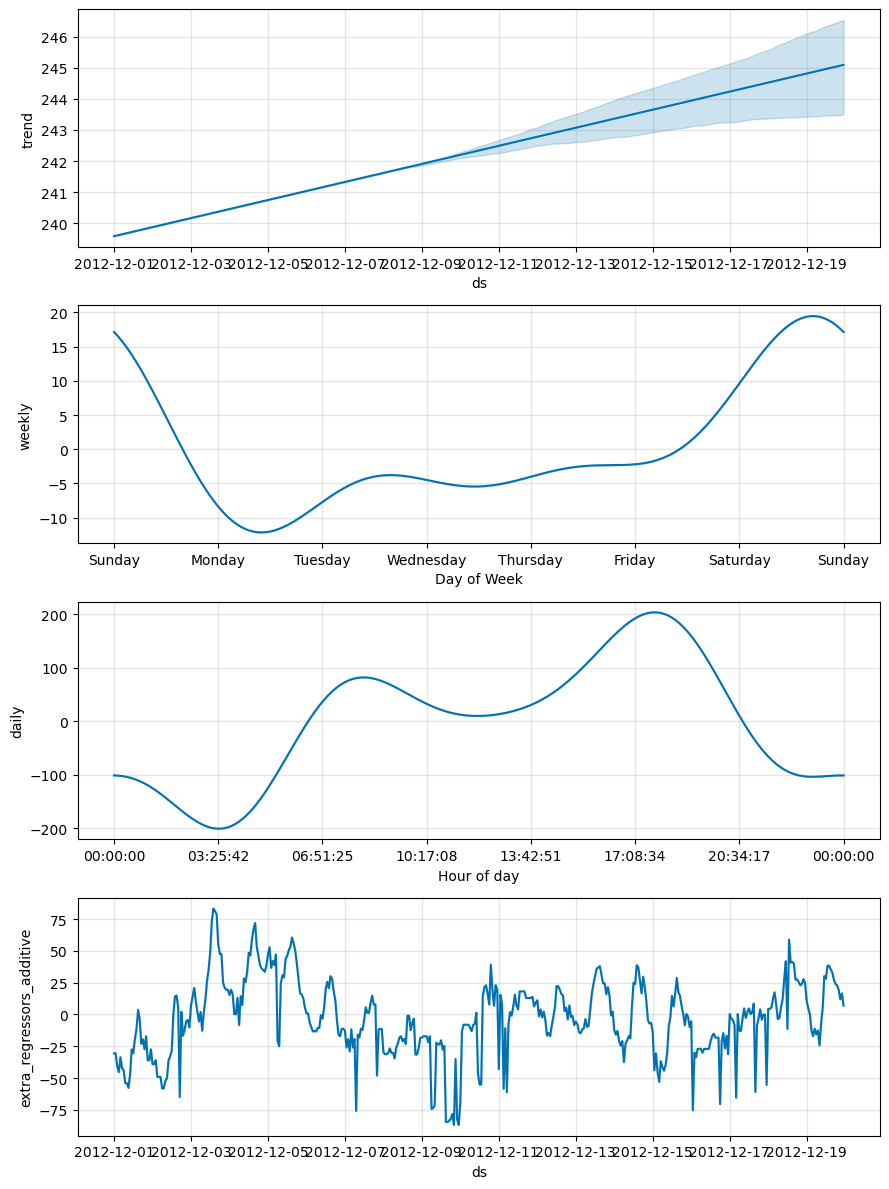

In [ ]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Load training data
df = train

# Rename columns for Prophet
df.rename(columns={'date_hour': 'ds', 'cnt': 'y'}, inplace=True)


# Select relevant external regressors
external_regressors = ['holiday', 'temp', 'hum', 'windspeed', 'weekend', 
                       'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4',]

# Prepare data for Prophet
model_data = df[['ds', 'y'] + external_regressors]

# Initialize the Prophet model
model = Prophet()

# Add external regressors
for regressor in external_regressors:
    model.add_regressor(regressor)


# Fit the model on training data
model.fit(model_data)

# Load the test set (future data to predict `cnt`)
test_df = test
test_df.rename(columns={'date_hour': 'ds'}, inplace=True)

# Ensure the test set contains all regressors used during training
future = test_df[['ds'] + external_regressors]

# Make predictions on the test set
forecast = model.predict(future)

# Display predictions
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# Evaluate the model using cross-validation
df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='18 days')
metrics = performance_metrics(df_cv)
print(metrics)

# Plot forecast
model.plot(forecast)

# Plot components (trends, seasonality, regressors)
model.plot_components(forecast)
# Create a DataFrame with the predicted values
prophet_predictions = test_df[['ds']].copy()
prophet_predictions['yhat'] = forecast['yhat']

prophet_predictions.rename(columns={'ds': 'date_hour', 'yhat': 'cnt'}, inplace=True)

# Save the predictions to a CSV file
prophet_predictions.to_csv('prophet.csv', index=False)

### 5.7.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

In [ ]:
# Load training data
df = train

# Rename columns for Prophet
df.rename(columns={'date_hour': 'ds', 'cnt': 'y'}, inplace=True)

# Select relevant external regressors
external_regressors = ['holiday', 'temp', 'hum', 'windspeed', 'weekend', 
                       'weathersit_1', 'weathersit_2', 'weathersit_3']

# Prepare data for Prophet
model_data = df[['ds', 'y'] + external_regressors]

# Initialize the Prophet model
model = Prophet()

# Add external regressors
for regressor in external_regressors:
    model.add_regressor(regressor)

# Perform a time-based train-test split (e.g., 80% train, 20% test)
train_size = int(len(df) * 0.95)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Prepare training data
train_data = train_df[['ds', 'y'] + external_regressors]

# Initialize and train the model
model = Prophet()
# Add all regressors to the model
for regressor in external_regressors:
    model.add_regressor(regressor)

# Fit the model
model.fit(train_data)

# Use the test set for predictions
test_data = test_df[['ds'] + external_regressors]

# Predict on the test set
forecast = model.predict(test_data)

# Combine predictions with actual values
results = pd.concat([test_df[['ds', 'y']].reset_index(drop=True),
                     forecast[['ds', 'yhat']].reset_index(drop=True)], axis=1)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(results['y'], results['yhat']))

print(f"RMSE: {rmse}")


14:50:13 - cmdstanpy - INFO - Chain [1] start processing
14:50:15 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 136.16769316679975


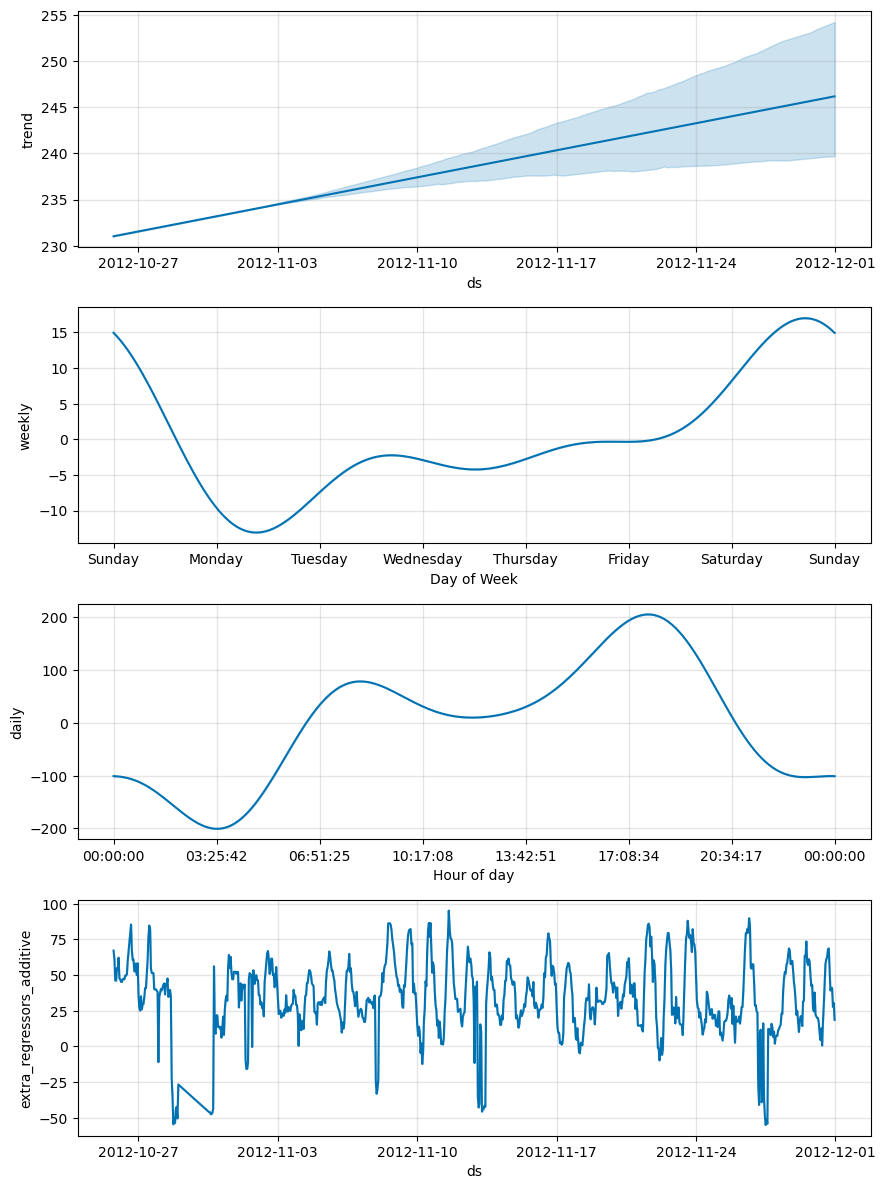

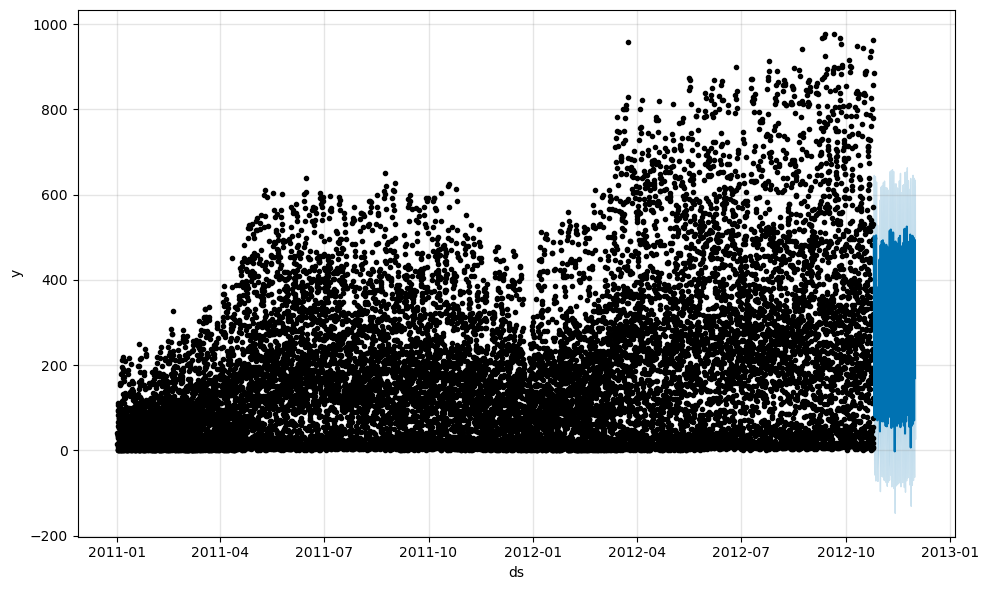

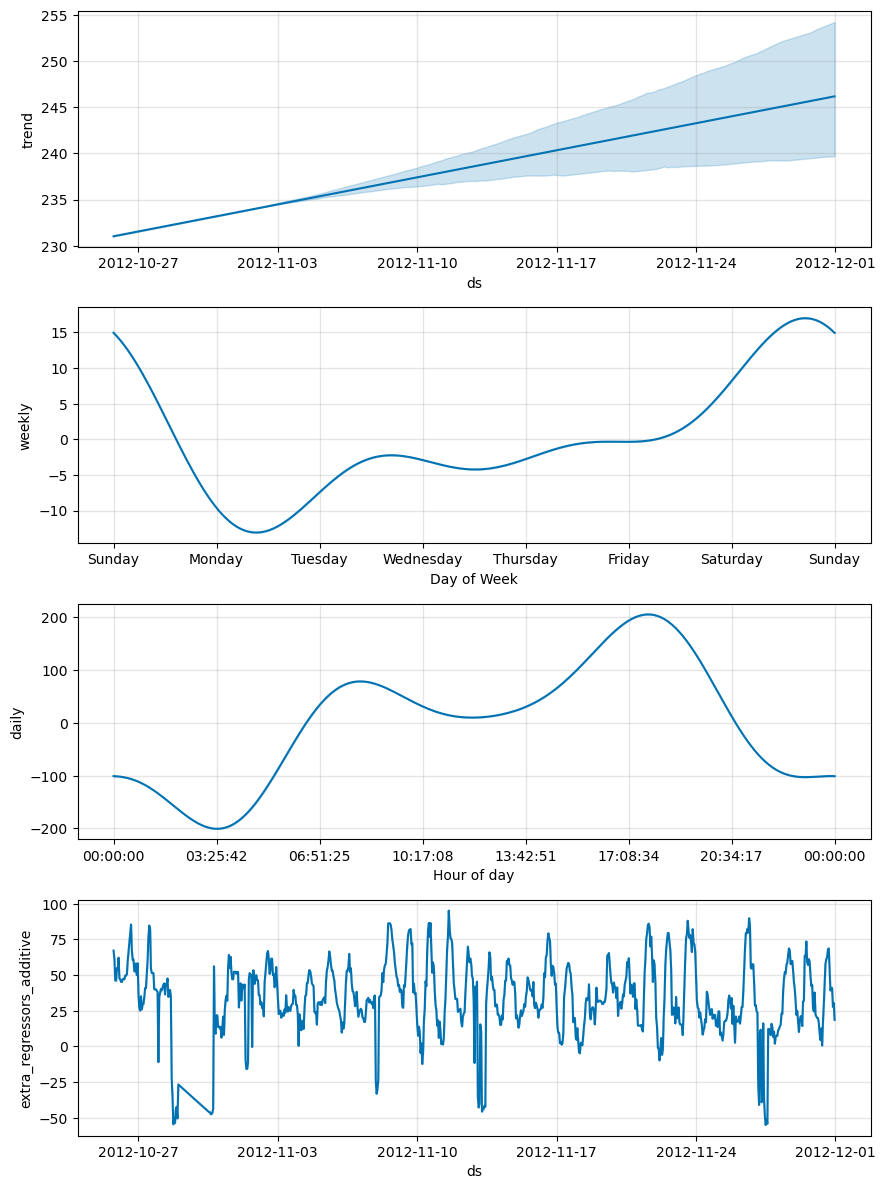

In [68]:
# Plot forecast
model.plot(forecast)

# Plot components (trends, seasonality, regressors)
model.plot_components(forecast)


### 5.7.2 Geef toelichting in de werking van het model en de gekozen parameters

Prophet is een forecasting machine learning model, die makkelijker in gebruik wilt zijn dan bijvoorbeeld arima. Prophet doet namelijk zelf al veel zoals seasonality herkennen op bijvoorbeeld dagelijks en jaarlijkse basis.

Prophet modeleerd tijd serie modellen zoals volgt:

$$y(t)=g(t)+s(t)+h(t)+ϵt$$

Here is the corrected version:

**Hier:**

- **g(t):** Modellerende de trend (lineaire of logistieke groei).
- **s(t):** Vangt de seizoensgebondenheid op (bijv. wekelijks, maandelijks).
- **h(t):** Verantwoordelijk voor de effecten van vakanties of andere speciale evenementen.
- **ϵt:** Houdt rekening met de ruis.

**Trendcomponent:**
- **Lineaire groei:** Wordt gebruikt voor datasets met een constante groei of daling.
- **Logistische groei:** Dit kan omgaan met data die in de loop van de tijd stabiliseren.

**Seizoensgebondenheid:**
- Gebaseerd op uitbreidingen van de Fourier-serie voor vloeiende periodieke patronen.
- Inclusief jaarlijkse, wekelijkse of door ons gedefinieerde seizoensinvloeden.

**Effecten van vakanties:**
- Hiermee kunnen gebruikers speciale evenementen opgeven die invloed kunnen hebben op trends (bijv. Black Friday, Kerstmis). Voor ons is dit waarschijnlijk niet belangrijk.

Melanie. (2024, February 27). Facebook Prophet : All you need to know. Data Science Courses | DataScientest. https://datascientest.com/en/facebook-prophet-all-you-need-to-know

Taylor SJ, Letham B. 2017. Forecasting at scale. PeerJ Preprints 5:e3190v2 https://doi.org/10.7287/peerj.preprints.3190v2


**Hoe zit het met ons model?**

In de grafieken van ons model zien we dat het de trend vrij goed oppakt, ook de wekelijke en dagelijks seizoens gebondenheid lijkt goed in kaart te worden gebracht, maar wat opvalt in de uiteindelijke predictions is dat het model binnen een heel conservatief gebied voorspeld. Het lijkt erop dat het alleen data punten voorspeld dit meer lijken op het eerste jaar dan het 2de jaar waar de verhuur aantallen zijn gegroeid per dag. Hierdoor is de MSRE vrij hoog met 136.

### 5.7.3 Pas het model toe op de testset en upload het resultaat op Kaggle

wordt gedaan in het model boven

## 5.8 Model 1 van hybdride modellen

Hybride model werkte niet zoals verwacht. We maken daarom hieronder een handmatige hybride model.

In [ ]:
model1 = XGBRegressor()
model2 = SARIMAX(endog=train['cnt'], order=(7, 0, 4), seasonal_order=(7, 0, 4, 24))

model1.fit(data.X_train, data.y_train.values.ravel())
train_predict1 = model1.predict(data.X_train)
test_predict1 = model1.predict(data.X_test)

y_train_res = data.y_train.values.ravel() - train_predict1
y_test_res = data.y_test.values.ravel() - test_predict1

model2.fit(data_s.X_train_s, y_train_res)
train_predictions_total = model2.predict(data_s.X_train_s) + train_predict1
test_predictions_total = model2.predict(data_s.X_test_s) + test_predict1

print('train r2', r2_score(data.y_train.values.ravel(), train_predictions_total))
print('test r2', r2_score(data.y_test.values.ravel(), test_predictions_total))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Hier wordt handmatig het een model gesimuleerd door de resultaten van 2 modellen te combineren

In [ ]:
xgb = pd.read_csv('XGBRegressor_1.csv')
sari = pd.read_csv('SARIMAX_2.csv')

merged = pd.merge(xgb, sari, on='date_hour', suffixes=('_xgb', '_sari'))
merged[['cnt_xgb', 'cnt_sari']] = merged[['cnt_xgb', 'cnt_sari']].clip(lower=0)

merged['cnt'] = np.where(
    merged['cnt_xgb'] == 0, merged['cnt_sari'],
    np.where(
        merged['cnt_sari'] == 0, merged['cnt_xgb'],
        (merged['cnt_xgb'] + merged['cnt_sari']) / 2
    )
)

merged[['date_hour', 'cnt']].to_csv('hybrid_model_XGB_1_with_SAR_2.csv', index=False)

### 5.8.2 Geef toelichting in de werking van het model en de gekozen parameters

Er is besloten om het SARIMA model met de XGBoost te combineren. 

De keuze hiervoor is gebasseerd op de sterke punten van beide modellen:

Zo is SARIMAX speciaal gemaakt voor het voorspellen aan de hand van time series datasets. Daarom is het dus ook geschikt om de onderliggende tijdreeks (inclusief trends, seizoensinvloeden en autocorrelatie) mee te nemen in de voorspellingen. XGBoost is weer een model dat goed in het oppakken van niet-lineaire, complexe patronen in datasets, die niet door SARIMAX gemodelleerd kunnen worden. 

De modellen vullen elkaar dus op een goede manier aan (SARIMA is goed met tijdreeksen, terwijl XGBoost beter is met niet-lineaire data). Door deze twee modellen te samen te voegen als hybride model worden van deze specifieke modellen de sterke punten combinineerd om zo tot betere voorspellingen te komen. 


Gebruikte bronnen staat bij de eerdere uitleg van de gebruikte modellen

### 5.8.3 Pas het model toe op de testset en upload het resultaat op Kaggle

Gebeurt hierboven

# 6. Bevindingen

## 6.1 Geef een beknopt overzicht van de resultaten

| Model Name               | Kaggle Score | msre test train split notebook                                                                                             | parameters
|--------------------------|--------------|---------------------------------------------------------------------------                                      |-----------------------------
| LinearRegression         | 103.24277    | 100.94329353607232                                                                                                                | ()
| DecisionTreeRegressor    | 85.22603     | 80.878116112334                                                                                                                | {'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 6}    
| RandomForestRegressor    | 81.39871     | 72.40527178690326                                                                                                                | {'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
| KNeighborsRegressor      | 178.13076    | 211.5382701633656                                                                                                                | {'n_neighbors': 5, 'weights': 'distance'} 
| XGBRegressor             | 50.81213     | 52.92540925621379                                                                                                                | {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100} 
| SARIMAX                  | 116.22463    | 85.67368673663154                                                                                                                | (order=(7, 1, 4), seasonal_order=(3, 1, 1, 24))
| Prophet                  | 111.86678    | 136.16769316679975                                                                                                                | ()

## 6.2 Welke model presteert het beste? Welke parameters gebruikte deze?

The XGB presteert het beste met de parameters: ('learning_rate'= 0.1, 'max_depth'= 5, 'n_estimators' = 100)

# 7. Conclusie en aanbevelingen

## 7.1 welke features hadden uiteindelijk het meeste invloed op de voorspelling?

Aan de hand van de feature importance functie kunnen we concluderen dat er een aantal features meer invloed hebben dan andere functies op de voorspellingen. De features met de meeste invloed (top 5) zijn:

- sin_hour_8318: dit zijn de cyclische representaties van de jaarlijke periode. 
- trend: dit is de lineaire trend kolom die is toegevoegd aan de dataset.
- sin_hour_24 / cos_hour_24: dit zijn de cyclische representaties van de dagelijkse / 24-uurs periode.
- weekend:  dit is de kolom die aangeeft of het weekend is of niet.
- atemp: dit is de kolom die de genormaliseerde gevoelstemperatuur bevat.

## 7.2 Sluit dit aan op de EDA?

Hierboven zijn de vijf features beschreven die het meeste invloed hebben op de voorspellingen. Hieronder zal worden uitgelegd of dit ook overeenkomst met de vooraf gemaakte EDA:
- sin_hour_8318: uit de fourier analyse is gekomen dat er sprake was van een dominante frequentie bij een jaarlijkse periode. Het feit dat dit ook een significante invloed heeft op de voorspellingen sluit dus inderdaad aan op de EDA. 
- trend: uit de EDA is niet echt gebleken dat er sprake was van een lineaire trend in de verhuuraantallen. Toch heeft de trend kolom een hoge feature importance. Dit sluit dus niet aan op de EDA.
- sin_hour_24 / cos_hour_24: hiervoor geldt dezelfde beargumentering als voor de jaarlijkse representatie. 
- weekend: in de grafiek in de EDA (dayname vs cnt) is gebleken dat op de zondag het verhuuraantal het laagst was. Uit de feature importances is gebleken dat de 'weekend' kolom veel invloed heeft op de voorspellingen, dus sluit het ook aan op de EDA. 
- atemp: in de EDA (histplot) is te zien dat bij een gemiddelde temperatuur het verhuuraantal het hoogst is. Bij een hele lage of juist hele hoge temperatuur worden de verhuuraantallen minder. Atemp komt ook uit de feature importances als een belangrijke kolom, dus sluit het zeker aan bij de EDA. 

Over het algemeen sluit aan het begin gemaakte EDA, dus zeer goed aan op de gevonden feature importances bij het maken van de voorspellingen.

## 7.3 Welk advies kun je op basis hiervan geven aan de verhuurder?

Op basis van de belangrijkse kolommen kunnen we een advies geven aan de verhuurder.

Er is gebleken dat er cyclische patronen in een jaar zijn en dat er dus seizoensinvloeden zijn. Gedurende het jaar zullen er dus ook piek- en dalmomenten zijn in de verhuuraantallen. De verhuurder zou bijvoorbeeld prijsacties in de dalperiodes kunnen overwegen om de vraag te stimuleren. Rondom de piekseizoenen zou die bijvoorbeeld ook marketingcampagnes kunnen doen om zo een nog groter bereik te krijgen.

Ook is er in de data gevonden dat er sprake is van een lineaire trend binnen de verhuuraantallen. Als verhuurder zou je hierop kunnen anticiperen door te investeren in meer producten om aan de groeiende vraag te voldoen. 

Daarnaast is er te zien dat op bepaalde momenten van de dag de verhuuraantallen hoger liggen dan andere momenten (pieken zijn 8 uur 's ochtends en 6 uur 's avonds). De verhuurder zou dus kunnen zorgen dat er op deze piekmomenten voldoende beschikbaarheid is. Ook zou er overwogen kunnen worden een hogere prijs tijdens de spitsuren te hanteren en korting in de daluren. Dit zorgt ervoor dat de inkomsten als de spreiding van de vraag worden geoptimaliseert.

Uit de EDA blijkt ook dat de verhuuraantallen in het weekend (met name de zondag) een stuk lager liggen dat de rest van de week. Als verhuurder zou je kunnen overwegen om bijvoorbeeld door de weeks langere openingstijden / huurperiodes te hebben dan in het weekend. 

Tot slot is er gezien dat de verhuuraantallen het hoogst liggen bij een gemiddelde tempuratuur (dus minder verhuur bij een hele lage of juist hoge temperatuur). In periodes met een aangename, gemiddelde temperatuur zou je tijdelijk extra producten beschikbaar kunnen stellen. 

Dit is ons advies aan de verhuurder op basis van de bevindingen in ons onderzoek. 

## 7.4 Welk model zou je adviseren aan de verhuurder? Waarom? Is dit per definitie het model met de beste voorspellingen of zijn  er ook andere overwegingen? Zo ja, welke?

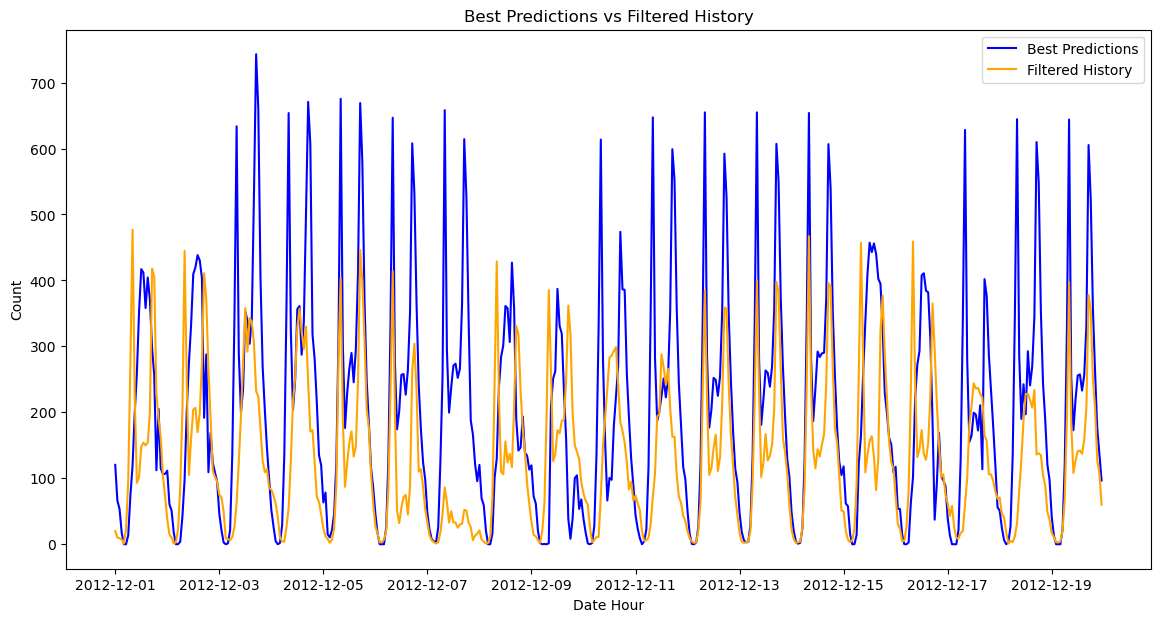

In [ ]:
best = pd.read_csv('XGBRegressor_2.csv')
history = pd.read_csv('train.csv')
history['date_hour'] = pd.to_datetime(history['date_hour'])
best['date_hour'] = pd.to_datetime(best['date_hour'])
one_year_ago_dates = best['date_hour'] - pd.DateOffset(years=1)
filtered_history = history[history['date_hour'].isin(one_year_ago_dates)]
filtered_history['date_hour'] = filtered_history['date_hour'] + pd.DateOffset(years=1)

plt.figure(figsize=(14, 7))
plt.plot(best['date_hour'], best['cnt'], label='Best Predictions', color='blue')
plt.plot(filtered_history['date_hour'], filtered_history['cnt'], label='Filtered History', color='orange')
plt.title('Best Predictions vs Filtered History')
plt.xlabel('Date Hour')
plt.ylabel('Count')
plt.legend()

plt.show()

Dit laat onze beste predictions zien tegenover de werkelijke data van dezelfde periode een jaar eerder.

Wij raden aan om XGBRegressor te gebruiken, hoewel het model nog niet volledig accuraat is. Voorspelt het wel op een goede manier de structuur. Hiermee herkent XGB de trends en patronen in de data ook al zijn de exact voorspelde waarden niet nauwkeurig. Met meer data zal het model accurater worden, mindere hoge pieks voorspellen en anomalies kunnen detecteren zoals te zien bij 2012-12-07.
 
XGB biedt dus veel potentieel voor latere verbeteringen, hiermee adviseren we daarom om dit model te gebruiken en vooral de focus te leggen naar het verzamelen van meer data. 

<details>
<summary>Note</summary>
<span style="font-size: smaller;">er is github copilot gebruikt bij het schrijven van sommige docstrings/comments</span>
</details>
